In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from sklearn import preprocessing
import missingno as msno
from datetime import timedelta
import sys
import os
import math
from scipy.stats import t
import time
# from tabulate import tabulate

In [120]:
# # 구글 드라이브에 마운트 해주기
# from google.colab import drive
# drive.mount('/content/drive')

# # 작업 디렉토리 변경
# os.chdir("/content/drive/MyDrive/Edge box anomaly detection paper/전체 코드 및 데이터 일괄 정리")

In [121]:
# 데이터프레임 불러오기
df = pd.DataFrame(pd.read_csv('df1_2_HRV_30.csv', index_col=False))

df = df[['id', 'hypertension', 'measure_time', 'heart_rate']]

# 시퀀스 길이와 시작 위치 정의
sequence_length = 29  # 시퀀스 길이 코드 맨 상부에서 정의
# batch_size = 30 # 배치사이즈 코드 맨 상부에서 정의
count = 30  # 데이터 연속되는 최소 갯수 설정 변수

df

,id,hypertension,measure_time,heart_rate
0,11002,0,2023-03-27 15:01:00,79
1,11002,0,2023-03-27 15:02:00,77
2,11002,0,2023-03-27 15:03:00,76
3,11002,0,2023-03-27 15:04:00,87
4,11002,0,2023-03-27 15:05:00,80
...,...,...,...,...
147084,51056,0,2022-11-11 15:56:00,112
147085,51056,0,2022-11-11 15:57:00,110
147086,51056,0,2022-11-11 15:58:00,110
147087,51056,0,2022-11-11 15:59:00,110


In [122]:

df['measure_time'] = pd.to_datetime(df['measure_time'])
# 연월일 추가
df["date"] =df["measure_time"].dt.date
# 연도 추가
df["year"] = df["measure_time"].dt.year
# 월 추가
df["month"] = df["measure_time"].dt.month
# 일 추가
df["day"] = df["measure_time"].dt.day
# 시간 추가
df["hour"] = df["measure_time"].dt.hour
# 분 추가
# df["minute"] = df["measure_time"].dt.minute
# 초 추가
# df["second"] = df["measure_time"].dt.second
# 마이크로초 추가
# df["microsecond"] = df["measure_time"].dt.microsecond
# 요일 추가
df["week"] = df["measure_time"].dt.day_name()
# 요일 숫자 추가
# df["week_cnt"] = df["measure_time"].dt.weekday
# 해당월의 시작인가
# df["start_day"] = df["measure_time"].dt.is_month_start
# 해당월의 끝인가
# df["end_day"] = df["measure_time"].dt.is_month_end
df

,id,hypertension,measure_time,heart_rate,date,year,month,day,hour,week
0,11002,0,2023-03-27 15:01:00,79,2023-03-27,2023,3,27,15,Monday
1,11002,0,2023-03-27 15:02:00,77,2023-03-27,2023,3,27,15,Monday
2,11002,0,2023-03-27 15:03:00,76,2023-03-27,2023,3,27,15,Monday
3,11002,0,2023-03-27 15:04:00,87,2023-03-27,2023,3,27,15,Monday
4,11002,0,2023-03-27 15:05:00,80,2023-03-27,2023,3,27,15,Monday
...,...,...,...,...,...,...,...,...,...,...
147084,51056,0,2022-11-11 15:56:00,112,2022-11-11,2022,11,11,15,Friday
147085,51056,0,2022-11-11 15:57:00,110,2022-11-11,2022,11,11,15,Friday
147086,51056,0,2022-11-11 15:58:00,110,2022-11-11,2022,11,11,15,Friday
147087,51056,0,2022-11-11 15:59:00,110,2022-11-11,2022,11,11,15,Friday


In [123]:

grouped = df.groupby('hypertension')

df_hypertension = grouped.get_group(1)
df_hypertension_not = grouped.get_group(0)

# 결과 출력
print("고혈압 데이터 개수:", len(df_hypertension))
print("정상 데이터 개수:", len(df_hypertension_not))

df_hypertension_not.reset_index(drop=True, inplace=True)

고혈압 데이터 개수: 6330
정상 데이터 개수: 140759


In [124]:
df_hypertension_id = df[df['hypertension'] == 1]['id'].unique().tolist()
df_hypertension_id.sort()
df_hypertension_not_id = df[df['hypertension'] == 0]['id'].unique().tolist()
df_hypertension_not_id.sort()

# 결과 출력
print("고혈압 id 리스트:", df_hypertension_id)
print("고혈압 인원 수:", len(df_hypertension_id))
print("정상 id 리스트:", df_hypertension_not_id)
print("정상 인원 수:", len(df_hypertension_not_id))

고혈압 id 리스트: [11005, 22021, 22042, 22043, 23026, 31006, 31007, 32007, 32028, 32030, 32032, 32044, 32051, 32053, 32058, 32066, 32073, 32084, 32085, 32089, 32091, 32108, 51048]
고혈압 인원 수: 23
정상 id 리스트: [11002, 11003, 11004, 13001, 13004, 13006, 21006, 21008, 21010, 21011, 21012, 21013, 21020, 21021, 21022, 21023, 21026, 21029, 21035, 21040, 22001, 22003, 22004, 22005, 22006, 22007, 22010, 22012, 22015, 22018, 22022, 22027, 22029, 22033, 22034, 22035, 22036, 22037, 22038, 22039, 22045, 23001, 23002, 23003, 23004, 23009, 23010, 23011, 23016, 23018, 23019, 23021, 23022, 23027, 23029, 23030, 23039, 23040, 23042, 24001, 24003, 24004, 24006, 24007, 24010, 31001, 31003, 31011, 31012, 31015, 31019, 31021, 31025, 31028, 31029, 31031, 31032, 31033, 31034, 31035, 31036, 31037, 31038, 31039, 31041, 31044, 31045, 31048, 31052, 31054, 31055, 31056, 31057, 32002, 32003, 32004, 32005, 32009, 32010, 32011, 32012, 32013, 32014, 32015, 32016, 32017, 32018, 32019, 32020, 32021, 32022, 32023, 32026, 32027, 320

In [125]:
# 새벽, 오전, 오후, 저녁으로 데이터 분류
df_hypertension_early_morning = df[(df['hypertension'] == 1) & (df['hour'] >= 0) & (df['hour'] < 6)]
df_hypertension_morning = df[(df['hypertension'] == 1) & (df['hour'] >= 6) & (df['hour'] < 12)]
df_hypertension_afternoon = df[(df['hypertension'] == 1) & (df['hour'] >= 12) & (df['hour'] < 18)]
df_hypertension_late_night = df[(df['hypertension'] == 1) & (df['hour'] >= 18) & (df['hour'] <= 23)]

df_hypertension_not_early_morning = df[(df['hypertension'] == 0) & (df['hour'] >= 0) & (df['hour'] < 6)]
df_hypertension_not_morning = df[(df['hypertension'] == 0) & (df['hour'] >= 6) & (df['hour'] < 12)]
df_hypertension_not_afternoon = df[(df['hypertension'] == 0) & (df['hour'] >= 12) & (df['hour'] < 18)]
df_hypertension_not_late_night = df[(df['hypertension'] == 0) & (df['hour'] >= 18) & (df['hour'] <= 23)]

# 결과 출력
print("early_morning 고혈압 데이터 개수:", len(df_hypertension_early_morning))
print("early_morning 정상 데이터 개수:", len(df_hypertension_not_early_morning))
df_hypertension_not_early_morning

early_morning 고혈압 데이터 개수: 972
early_morning 정상 데이터 개수: 35316


,id,hypertension,measure_time,heart_rate,date,year,month,day,hour,week
998,11004,0,2023-06-15 04:59:00,87,2023-06-15,2023,6,15,4,Thursday
999,11004,0,2023-06-15 05:00:00,84,2023-06-15,2023,6,15,5,Thursday
1000,11004,0,2023-06-15 05:01:00,83,2023-06-15,2023,6,15,5,Thursday
1001,11004,0,2023-06-15 05:02:00,82,2023-06-15,2023,6,15,5,Thursday
1002,11004,0,2023-06-15 05:03:00,74,2023-06-15,2023,6,15,5,Thursday
...,...,...,...,...,...,...,...,...,...,...
144372,51007,0,2022-11-29 05:55:00,75,2022-11-29,2022,11,29,5,Tuesday
144373,51007,0,2022-11-29 05:56:00,79,2022-11-29,2022,11,29,5,Tuesday
144374,51007,0,2022-11-29 05:57:00,80,2022-11-29,2022,11,29,5,Tuesday
144375,51007,0,2022-11-29 05:58:00,71,2022-11-29,2022,11,29,5,Tuesday


# EDA

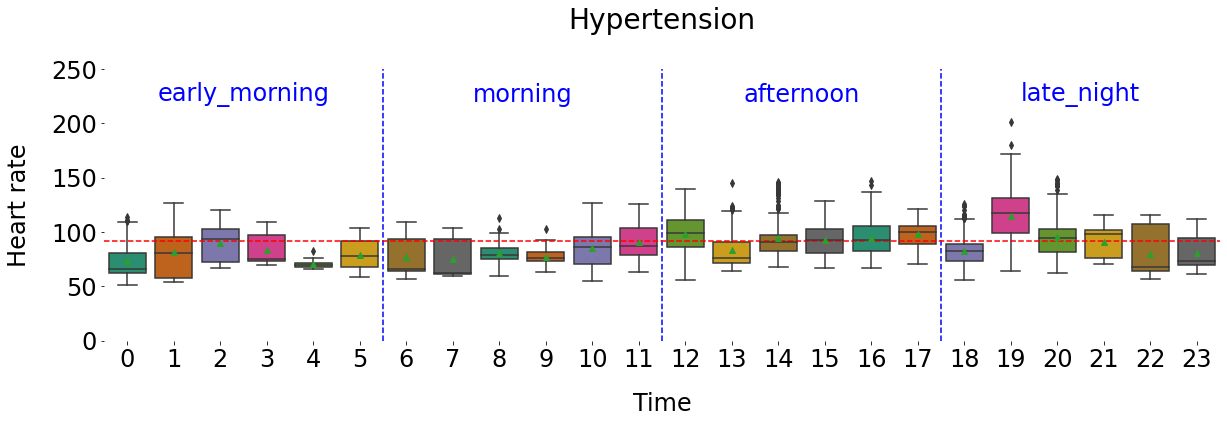

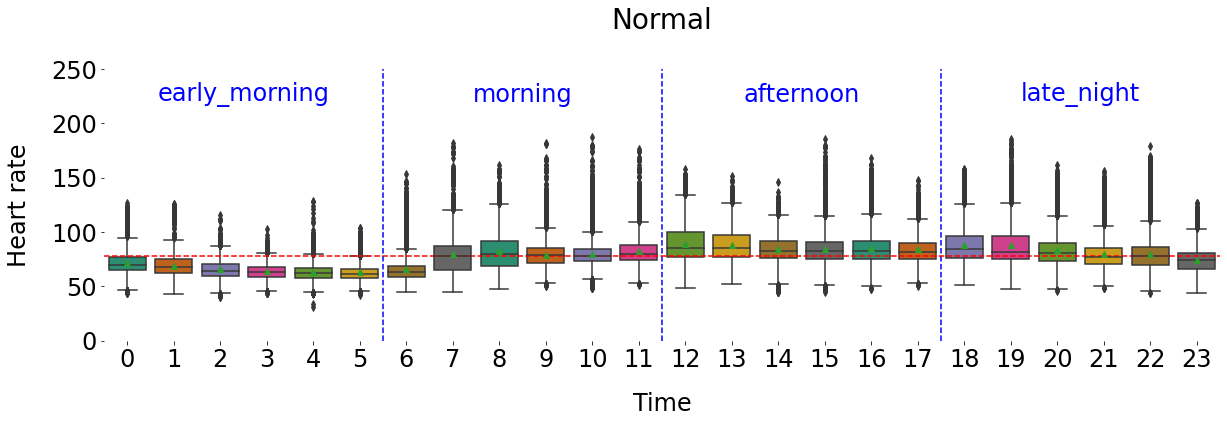

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

def box_plot_with_lines(df, value_colname, facet_colname, title, figscale=1, mpl_palette_name='Dark2', **kwargs):
    # Create a box plot
    plt.figure(figsize=(20, 5), facecolor='white')
    ax = sns.boxplot(df[value_colname], df[facet_colname], palette=mpl_palette_name, **kwargs)

    # Add vertical lines at specific positions
    ax.axvline(x=5.5, color='b', linestyle='--')
    ax.axvline(x=11.5, color='b', linestyle='--')
    ax.axvline(x=17.5, color='b', linestyle='--')

    ax.text(2.5, 215, 'early_morning', ha='center', va='bottom', color='b', fontsize=24)
    ax.text(8.5, 215, 'morning', ha='center', va='bottom', color='b', fontsize=24)
    ax.text(14.5, 215, 'afternoon', ha='center', va='bottom', color='b', fontsize=24)
    ax.text(20.5, 215, 'late_night', ha='center', va='bottom', color='b', fontsize=24)

    sns.despine(top=True, right=True, bottom=True, left=True)

#     # Adjust legend position
#     ax.legend(loc='upper right')

    df_dif = df['heart_rate']
    min_value = df[facet_colname].min()  # 최소 값 계산
    max_value = df[facet_colname].max()  # 최대 값 계산
    mean_value = df_dif.mean()  # 평균 값 계산
    quantiles_25 = df[facet_colname].quantile(0.25)
    quantiles_75 = df[facet_colname].quantile(0.75)

    ax.set_ylim(0, 250)  # y축 범위 지정
    ax.axhline(y=mean_value, color='r', linestyle='--')  # 평균 값 기준선 추가
    
    ax.set_ylabel('Heart rate', fontsize=24, labelpad=20)  # Y 라벨 폰트 크기 조절
    ax.set_xlabel('Time', fontsize=24, labelpad=20)  # X 라벨 폰트 크기 조절
    
    ax.tick_params(axis='y', labelsize=24)
    ax.tick_params(axis='x', labelsize=24)
    
    # Add title and adjust its position
    ax.set_title(title, pad=40, fontsize=28)

# df_hypertension 그래프
box_plot_with_lines(df_hypertension, 'hour', 'heart_rate', title='Hypertension', showmeans=True)

# df_hypertension_not 그래프
box_plot_with_lines(df_hypertension_not, 'hour', 'heart_rate', title='Normal', showmeans=True)

# 그래프 보여주기
plt.show()


In [127]:
df_tem = df_hypertension_not_early_morning.reset_index(drop=True)

df_tem = df_tem.sort_values(by=['id', 'measure_time'], ascending=[True, True])

# Convert 'measure_time' to datetime format
df_tem['measure_time'] = pd.to_datetime(df_tem['measure_time'])

# Group by 'id' and calculate the time differences
df_tem['time_diff'] = df_tem.groupby('id')['measure_time'].diff()

# Check if time differences are 1 minute or less
df_tem['time_interval'] = df_tem['time_diff'].dt.total_seconds() / 60

# 최초 처음 데이터 타임인터벌 없음 처리
df_tem.loc[df_tem['time_interval'].isna(), 'time_interval'] = 0

# id 바뀔때 타임인터벌 처리
df_tem.loc[df_tem['id'] != df_tem['id'].shift(1), 'time_interval'] = 0

df_tem['time_interval'] = df_tem['time_interval'].astype(int)

df_hypertension_not_early_morning_time = df_tem
df_hypertension_not_early_morning_time

,id,hypertension,measure_time,heart_rate,date,year,month,day,hour,week,time_diff,time_interval
0,11004,0,2023-06-15 04:59:00,87,2023-06-15,2023,6,15,4,Thursday,NaT,0
1,11004,0,2023-06-15 05:00:00,84,2023-06-15,2023,6,15,5,Thursday,0 days 00:01:00,1
2,11004,0,2023-06-15 05:01:00,83,2023-06-15,2023,6,15,5,Thursday,0 days 00:01:00,1
3,11004,0,2023-06-15 05:02:00,82,2023-06-15,2023,6,15,5,Thursday,0 days 00:01:00,1
4,11004,0,2023-06-15 05:03:00,74,2023-06-15,2023,6,15,5,Thursday,0 days 00:01:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...
35311,51007,0,2022-11-29 05:55:00,75,2022-11-29,2022,11,29,5,Tuesday,0 days 00:01:00,1
35312,51007,0,2022-11-29 05:56:00,79,2022-11-29,2022,11,29,5,Tuesday,0 days 00:01:00,1
35313,51007,0,2022-11-29 05:57:00,80,2022-11-29,2022,11,29,5,Tuesday,0 days 00:01:00,1
35314,51007,0,2022-11-29 05:58:00,71,2022-11-29,2022,11,29,5,Tuesday,0 days 00:01:00,1


In [128]:
df_tem = df_hypertension_not_early_morning_time

consecutive_count = 0
consecutive_data = []

# 시간 측정 시작
start_time = time.time()

for index, row in df_tem.iterrows():
    if row['time_interval'] == 1:
        consecutive_count += 1
        row['continuity'] = consecutive_count
        consecutive_data.append(row)
    else:
        row['continuity'] = consecutive_count
        consecutive_count = 0  # Reset the count

# 시간 측정 종료
end_time = time.time()

# 소요된 시간 출력
elapsed_time = end_time - start_time
print(f"코드 실행 소요 시간: {elapsed_time:.4f} 초")

df_tem = pd.DataFrame(consecutive_data)
# df_hr_select_con60min.to_csv('Data/Model/df_hr_select_con60min.csv', index=False)
df_hypertension_not_early_morning_time_continuity = df_tem.reset_index(drop=True)
df_hypertension_not_early_morning_time_continuity

코드 실행 소요 시간: 12.4325 초


,id,hypertension,measure_time,heart_rate,date,year,month,day,hour,week,time_diff,time_interval,continuity
0,11004,0,2023-06-15 05:00:00,84,2023-06-15,2023,6,15,5,Thursday,0 days 00:01:00,1,1
1,11004,0,2023-06-15 05:01:00,83,2023-06-15,2023,6,15,5,Thursday,0 days 00:01:00,1,2
2,11004,0,2023-06-15 05:02:00,82,2023-06-15,2023,6,15,5,Thursday,0 days 00:01:00,1,3
3,11004,0,2023-06-15 05:03:00,74,2023-06-15,2023,6,15,5,Thursday,0 days 00:01:00,1,4
4,11004,0,2023-06-15 05:04:00,73,2023-06-15,2023,6,15,5,Thursday,0 days 00:01:00,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34992,51007,0,2022-11-29 05:55:00,75,2022-11-29,2022,11,29,5,Tuesday,0 days 00:01:00,1,3
34993,51007,0,2022-11-29 05:56:00,79,2022-11-29,2022,11,29,5,Tuesday,0 days 00:01:00,1,4
34994,51007,0,2022-11-29 05:57:00,80,2022-11-29,2022,11,29,5,Tuesday,0 days 00:01:00,1,5
34995,51007,0,2022-11-29 05:58:00,71,2022-11-29,2022,11,29,5,Tuesday,0 days 00:01:00,1,6


In [129]:
df_tem = df_hypertension_not_early_morning_time_continuity
df_tem['start'] = ''
df_tem['end'] = ''

# 시간 측정 시작
start_time1 = time.time()

start_time = '' # end에 넣어줄 처음 시작 시간
current_data = []  # 현재 수집 중인 데이터를 저장할 리스트
collected_data = []  # 수집된 데이터를 저장할 리스트
collecting = False  # 데이터 수집 여부를 나타내는 변수
# count = 20  # 데이터 연속되는 최소 갯수 설정 변수 # 위에서 정의

df_continuity_check = df_tem
for index, row in df_continuity_check.iterrows():
  if (not collecting):
    if (row['continuity'] == 1) and (index < len(df_continuity_check) - 1) and (df_continuity_check.loc[index +1, 'continuity'] != 1):
      collecting = True
      start_time = row['measure_time']
      df_continuity_check.loc[index, 'start'] = start_time
      current_data.append(row)
  else:
    if (row['continuity'] != 1):
      current_data.append(row)
    else:
      if (index != 0) and (len(current_data) >= count) and (df_continuity_check.loc[index-1, 'continuity'] >= count) :
        df_continuity_check.loc[index-1, 'start'] = start_time
        df_continuity_check.loc[index-1, 'end'] = row['measure_time']
        current_data.pop()
        current_data.append(df_continuity_check.loc[index-1])
        collected_data.extend(current_data)
        current_data = []
        start_time = ''
        collecting = False
      else:
        current_data = []
        start_time = ''
        collecting = False

# 수집된 데이터로 데이터프레임 생성
df_continuity_check = pd.DataFrame(collected_data)
df_continuity_check.reset_index(drop=True, inplace=True)  # 인덱스 재설정 및 기존 인덱스 제거

# 시간 측정 종료
end_time1 = time.time()

# 소요된 시간 출력
elapsed_time = end_time1 - start_time1
print(f"코드 실행 소요 시간: {elapsed_time:.4f} 초")

print("인원수 :", df_continuity_check['id'].nunique())
print("최대값 :", df_continuity_check['heart_rate'].max())
print("최소값 :", df_continuity_check['heart_rate'].min())
# df_continuity_check.to_excel('df_hypertension_not_early_morning_time_continuity_30.xlsx', index=False)

df_hypertension_not_early_morning_time_continuity_30 = df_continuity_check
df_hypertension_not_early_morning_time_continuity_30

코드 실행 소요 시간: 2.3079 초
인원수 : 48
최대값 : 127
최소값 : 44


,id,hypertension,measure_time,heart_rate,date,year,month,day,hour,week,time_diff,time_interval,continuity,start,end
0,11004,0,2023-06-15 05:00:00,84,2023-06-15,2023,6,15,5,Thursday,0 days 00:01:00,1,1,,
1,11004,0,2023-06-15 05:01:00,83,2023-06-15,2023,6,15,5,Thursday,0 days 00:01:00,1,2,,
2,11004,0,2023-06-15 05:02:00,82,2023-06-15,2023,6,15,5,Thursday,0 days 00:01:00,1,3,,
3,11004,0,2023-06-15 05:03:00,74,2023-06-15,2023,6,15,5,Thursday,0 days 00:01:00,1,4,,
4,11004,0,2023-06-15 05:04:00,73,2023-06-15,2023,6,15,5,Thursday,0 days 00:01:00,1,5,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16100,32115,0,2023-05-26 01:05:00,88,2023-05-26,2023,5,26,1,Friday,0 days 00:01:00,1,29,,
16101,32115,0,2023-05-26 01:06:00,85,2023-05-26,2023,5,26,1,Friday,0 days 00:01:00,1,30,,
16102,32115,0,2023-05-26 01:07:00,86,2023-05-26,2023,5,26,1,Friday,0 days 00:01:00,1,31,,
16103,32115,0,2023-05-26 01:08:00,85,2023-05-26,2023,5,26,1,Friday,0 days 00:01:00,1,32,,


In [130]:
# 고혈압 데이터 확인
df_hypertension_early_morning

,id,hypertension,measure_time,heart_rate,date,year,month,day,hour,week
1029,11005,1,2023-03-23 05:28:00,68,2023-03-23,2023,3,23,5,Thursday
1030,11005,1,2023-03-23 05:29:00,69,2023-03-23,2023,3,23,5,Thursday
1031,11005,1,2023-03-23 05:30:00,82,2023-03-23,2023,3,23,5,Thursday
1032,11005,1,2023-03-23 05:31:00,81,2023-03-23,2023,3,23,5,Thursday
1033,11005,1,2023-03-23 05:32:00,83,2023-03-23,2023,3,23,5,Thursday
...,...,...,...,...,...,...,...,...,...,...
146208,51048,1,2022-09-17 00:21:00,107,2022-09-17,2022,9,17,0,Saturday
146209,51048,1,2022-09-17 00:22:00,99,2022-09-17,2022,9,17,0,Saturday
146210,51048,1,2022-09-17 00:23:00,81,2022-09-17,2022,9,17,0,Saturday
146211,51048,1,2022-09-17 00:24:00,94,2022-09-17,2022,9,17,0,Saturday


In [131]:
df_tem = df_hypertension_early_morning.reset_index(drop=True)

# Convert 'measure_time' to datetime format
df_tem['measure_time'] = pd.to_datetime(df_tem['measure_time'])

# Group by 'id' and calculate the time differences
df_tem['time_diff'] = df_tem.groupby('id')['measure_time'].diff()

# Check if time differences are 1 minute or less
df_tem['time_interval'] = df_tem['time_diff'].dt.total_seconds() / 60

# 최초 처음 데이터 타임인터벌 없음 처리
df_tem.loc[df_tem['time_interval'].isna(), 'time_interval'] = 0

# id 바뀔때 타임인터벌 처리
df_tem.loc[df_tem['id'] != df_tem['id'].shift(1), 'time_interval'] = 0

df_tem['time_interval'] = df_tem['time_interval'].astype(int)

df_hypertension_early_morning_time = df_tem
df_hypertension_early_morning_time

,id,hypertension,measure_time,heart_rate,date,year,month,day,hour,week,time_diff,time_interval
0,11005,1,2023-03-23 05:28:00,68,2023-03-23,2023,3,23,5,Thursday,NaT,0
1,11005,1,2023-03-23 05:29:00,69,2023-03-23,2023,3,23,5,Thursday,0 days 00:01:00,1
2,11005,1,2023-03-23 05:30:00,82,2023-03-23,2023,3,23,5,Thursday,0 days 00:01:00,1
3,11005,1,2023-03-23 05:31:00,81,2023-03-23,2023,3,23,5,Thursday,0 days 00:01:00,1
4,11005,1,2023-03-23 05:32:00,83,2023-03-23,2023,3,23,5,Thursday,0 days 00:01:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...
967,51048,1,2022-09-17 00:21:00,107,2022-09-17,2022,9,17,0,Saturday,0 days 00:01:00,1
968,51048,1,2022-09-17 00:22:00,99,2022-09-17,2022,9,17,0,Saturday,0 days 00:01:00,1
969,51048,1,2022-09-17 00:23:00,81,2022-09-17,2022,9,17,0,Saturday,0 days 00:01:00,1
970,51048,1,2022-09-17 00:24:00,94,2022-09-17,2022,9,17,0,Saturday,0 days 00:01:00,1


In [132]:
df_tem = df_hypertension_early_morning_time

consecutive_count = 0
consecutive_data = []

# 시간 측정 시작
start_time = time.time()

for index, row in df_tem.iterrows():
    if row['time_interval'] == 1:
        consecutive_count += 1
        row['continuity'] = consecutive_count
        consecutive_data.append(row)
    else:
        row['continuity'] = consecutive_count
        consecutive_count = 0  # Reset the count

# 시간 측정 종료
end_time = time.time()

# 소요된 시간 출력
elapsed_time = end_time - start_time
print(f"코드 실행 소요 시간: {elapsed_time:.4f} 초")

df_tem = pd.DataFrame(consecutive_data)
# df_hr_select_con60min.to_csv('Data/Model/df_hr_select_con60min.csv', index=False)
df_hypertension_early_morning_time_continuity = df_tem.reset_index(drop=True)
df_hypertension_early_morning_time_continuity

코드 실행 소요 시간: 0.3240 초


,id,hypertension,measure_time,heart_rate,date,year,month,day,hour,week,time_diff,time_interval,continuity
0,11005,1,2023-03-23 05:29:00,69,2023-03-23,2023,3,23,5,Thursday,0 days 00:01:00,1,1
1,11005,1,2023-03-23 05:30:00,82,2023-03-23,2023,3,23,5,Thursday,0 days 00:01:00,1,2
2,11005,1,2023-03-23 05:31:00,81,2023-03-23,2023,3,23,5,Thursday,0 days 00:01:00,1,3
3,11005,1,2023-03-23 05:32:00,83,2023-03-23,2023,3,23,5,Thursday,0 days 00:01:00,1,4
4,11005,1,2023-03-23 05:33:00,86,2023-03-23,2023,3,23,5,Thursday,0 days 00:01:00,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,51048,1,2022-09-17 00:21:00,107,2022-09-17,2022,9,17,0,Saturday,0 days 00:01:00,1,21
952,51048,1,2022-09-17 00:22:00,99,2022-09-17,2022,9,17,0,Saturday,0 days 00:01:00,1,22
953,51048,1,2022-09-17 00:23:00,81,2022-09-17,2022,9,17,0,Saturday,0 days 00:01:00,1,23
954,51048,1,2022-09-17 00:24:00,94,2022-09-17,2022,9,17,0,Saturday,0 days 00:01:00,1,24


In [133]:
df_tem = df_hypertension_early_morning_time_continuity
df_tem['start'] = ''
df_tem['end'] = ''

# 시간 측정 시작
start_time1 = time.time()

start_time = '' # end에 넣어줄 처음 시작 시간
current_data = []  # 현재 수집 중인 데이터를 저장할 리스트
collected_data = []  # 수집된 데이터를 저장할 리스트
collecting = False  # 데이터 수집 여부를 나타내는 변수
# count = 20  # 데이터 연속되는 최소 갯수 설정 변수 # 위에서 정의

df_continuity_check = df_tem
for index, row in df_continuity_check.iterrows():
  if (not collecting):
    if (row['continuity'] == 1) and (index < len(df_continuity_check) - 1) and (df_continuity_check.loc[index +1, 'continuity'] != 1):
      collecting = True
      start_time = row['measure_time']
      df_continuity_check.loc[index, 'start'] = start_time
      current_data.append(row)
  else:
    if (row['continuity'] != 1):
      current_data.append(row)
    else:
      if (index != 0) and (len(current_data) >= count) and (df_continuity_check.loc[index-1, 'continuity'] >= count) :
        df_continuity_check.loc[index-1, 'start'] = start_time
        df_continuity_check.loc[index-1, 'end'] = row['measure_time']
        current_data.pop()
        current_data.append(df_continuity_check.loc[index-1])
        collected_data.extend(current_data)
        current_data = []
        start_time = ''
        collecting = False
      else:
        current_data = []
        start_time = ''
        collecting = False

# 수집된 데이터로 데이터프레임 생성
df_continuity_check = pd.DataFrame(collected_data)
df_continuity_check.reset_index(drop=True, inplace=True)  # 인덱스 재설정 및 기존 인덱스 제거

# 시간 측정 종료
end_time1 = time.time()

# 소요된 시간 출력
elapsed_time = end_time1 - start_time1
print(f"코드 실행 소요 시간: {elapsed_time:.4f} 초")

print("인원수 :", df_continuity_check['id'].nunique())
print("최대값 :", df_continuity_check['heart_rate'].max())
print("최소값 :", df_continuity_check['heart_rate'].min())
# df_continuity_check.to_excel('df_hypertension_early_morning_time_continuity_30.xlsx', index=False)

df_hypertension_early_morning_time_continuity_30 = df_continuity_check
df_hypertension_early_morning_time_continuity_30

코드 실행 소요 시간: 0.0950 초
인원수 : 6
최대값 : 127
최소값 : 56


,id,hypertension,measure_time,heart_rate,date,year,month,day,hour,week,time_diff,time_interval,continuity,start,end
0,11005,1,2023-03-23 05:29:00,69,2023-03-23,2023,3,23,5,Thursday,0 days 00:01:00,1,1,,
1,11005,1,2023-03-23 05:30:00,82,2023-03-23,2023,3,23,5,Thursday,0 days 00:01:00,1,2,,
2,11005,1,2023-03-23 05:31:00,81,2023-03-23,2023,3,23,5,Thursday,0 days 00:01:00,1,3,,
3,11005,1,2023-03-23 05:32:00,83,2023-03-23,2023,3,23,5,Thursday,0 days 00:01:00,1,4,,
4,11005,1,2023-03-23 05:33:00,86,2023-03-23,2023,3,23,5,Thursday,0 days 00:01:00,1,5,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,32089,1,2023-05-09 01:00:00,61,2023-05-09,2023,5,9,1,Tuesday,0 days 00:01:00,1,59,,
511,32089,1,2023-05-09 01:01:00,61,2023-05-09,2023,5,9,1,Tuesday,0 days 00:01:00,1,60,,
512,32089,1,2023-05-09 01:02:00,59,2023-05-09,2023,5,9,1,Tuesday,0 days 00:01:00,1,61,,
513,32089,1,2023-05-09 01:03:00,59,2023-05-09,2023,5,9,1,Tuesday,0 days 00:01:00,1,62,,


In [134]:
df_tem = df_hypertension_early_morning_time_continuity_30

df_tem['rr'] = 60 / df_tem['heart_rate']  # bpm을 심박 간격으로 변환

diff_rr = np.diff(df_tem['rr'])
print('early_morning 고혈압 데이터 rmssd :', np.sqrt(np.mean(diff_rr ** 2)))
print('early_morning 고혈압 데이터 sdnn :',np.std(diff_rr))

early_morning 고혈압 데이터 rmssd : 0.03939749384207807
early_morning 고혈압 데이터 sdnn : 0.039396869096434084


In [135]:
df_tem = df_hypertension_early_morning_time_continuity_30

# 새로운 열 생성
df_tem['continuity1'] = 0

# 초기화 변수 설정
count = 1

# 반복문을 통해 값을 입력
for i in range(len(df_tem)):
    if (df_tem['continuity'].iloc[i] == 1) or (count > 30):
        count = 1
    df_tem.at[i, 'continuity1'] = count
    count += 1
    
    
# 현재 수집 중인 데이터를 저장할 리스트
current_data = []  
# 연속성이 만족하는 행들을 저장할 빈 리스트 생성
valid_rows = []
# 초기화 변수 설정
expected_value = 1

# 반복문을 통해 연속성 확인
for index, row in df_tem.iterrows():
    
    if row['continuity'] == 1:
        current_data = []
        expected_value = 1
        
    if expected_value > 30:
        valid_rows.extend(current_data)
        current_data = []
        expected_value = 1
        
    if row['continuity1'] == expected_value:
        current_data.append(row)
        expected_value += 1
        
valid_df = pd.DataFrame(valid_rows)
# valid_df.to_excel('df_hypertension_early_morning_time_continuity_30_count.xlsx', index=False)
df_hypertension_early_morning_time_continuity_30_count = valid_df

In [136]:
df_tem = df_hypertension_not_early_morning_time_continuity_30

df_tem['rr'] = 60 / df_tem['heart_rate']  # bpm을 심박 간격으로 변환

diff_rr = np.diff(df_tem['rr'])
print('early_morning 정상 데이터 rmssd :', np.sqrt(np.mean(diff_rr ** 2)))
print('early_morning 정상 데이터 sdnn :',np.std(diff_rr))

early_morning 정상 데이터 rmssd : 0.03971570139141858
early_morning 정상 데이터 sdnn : 0.03971570136196838


In [137]:
df_tem = df_hypertension_not_early_morning_time_continuity_30

# 새로운 열 생성
df_tem['continuity1'] = 0

# 초기화 변수 설정
count = 1

# 반복문을 통해 값을 입력
for i in range(len(df_tem)):
    if (df_tem['continuity'].iloc[i] == 1) or (count > 30):
        count = 1
    df_tem.at[i, 'continuity1'] = count
    count += 1
    
    
# 현재 수집 중인 데이터를 저장할 리스트
current_data = []  
# 연속성이 만족하는 행들을 저장할 빈 리스트 생성
valid_rows = []
# 초기화 변수 설정
expected_value = 1

# 반복문을 통해 연속성 확인
for index, row in df_tem.iterrows():
    
    if row['continuity'] == 1:
        current_data = []
        expected_value = 1
        
    if expected_value > 30:
        valid_rows.extend(current_data)
        current_data = []
        expected_value = 1
        
    if row['continuity1'] == expected_value:
        current_data.append(row)
        expected_value += 1
        
valid_df = pd.DataFrame(valid_rows)
# valid_df.to_excel('df_hypertension_not_early_morning_time_continuity_30_count.xlsx', index=False)
df_hypertension_not_early_morning_time_continuity_30_count = valid_df

In [138]:
df_hypertension_not_early_morning_time_continuity_30_count = df_hypertension_not_early_morning_time_continuity_30_count.reset_index(drop=True)
df_hypertension_not_early_morning_time_continuity_30_count

,id,hypertension,measure_time,heart_rate,date,year,month,day,hour,week,time_diff,time_interval,continuity,start,end,rr,continuity1
0,21012,0,2022-08-20 04:41:00,57,2022-08-20,2022,8,20,4,Saturday,0 days 00:01:00,1,1,,,1.052632,1
1,21012,0,2022-08-20 04:42:00,57,2022-08-20,2022,8,20,4,Saturday,0 days 00:01:00,1,2,,,1.052632,2
2,21012,0,2022-08-20 04:43:00,58,2022-08-20,2022,8,20,4,Saturday,0 days 00:01:00,1,3,,,1.034483,3
3,21012,0,2022-08-20 04:44:00,58,2022-08-20,2022,8,20,4,Saturday,0 days 00:01:00,1,4,,,1.034483,4
4,21012,0,2022-08-20 04:45:00,62,2022-08-20,2022,8,20,4,Saturday,0 days 00:01:00,1,5,,,0.967742,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13795,32115,0,2023-05-26 01:02:00,85,2023-05-26,2023,5,26,1,Friday,0 days 00:01:00,1,26,,,0.705882,26
13796,32115,0,2023-05-26 01:03:00,87,2023-05-26,2023,5,26,1,Friday,0 days 00:01:00,1,27,,,0.689655,27
13797,32115,0,2023-05-26 01:04:00,85,2023-05-26,2023,5,26,1,Friday,0 days 00:01:00,1,28,,,0.705882,28
13798,32115,0,2023-05-26 01:05:00,88,2023-05-26,2023,5,26,1,Friday,0 days 00:01:00,1,29,,,0.681818,29


In [139]:
df_tem = df_hypertension_not_early_morning_time_continuity_30_count

# 연속 데이터 확인 리스트
continuity_check = []

continuity_check_max_11_total = []

# 반복문을 통해 값을 입력
for i in range(len(df_tem)):
    
    continuity_check.append(df_tem.at[i, 'heart_rate'])
    
    if (i < len(df_tem)-1) and (df_tem['continuity1'].iloc[i+1] == 1):
        # continuity_check 리스트에서 최대값과 해당 인덱스 찾기
        max_value = max(continuity_check)
        max_index = continuity_check.index(max_value)

        # 최대값을 기준으로 전후 5개씩 추가하기
        continuity_check_max_11 = continuity_check[max_index-5:max_index+6]
        
        continuity_check_max_11_total.append(continuity_check_max_11)
        continuity_check = []

len(continuity_check_max_11_total)
continuity_check_max_11_total

[[59, 58, 61, 61, 61, 65, 60, 61, 59, 60, 59],
 [],
 [69, 68, 71, 70, 74, 77, 76, 77, 69, 75, 72],
 [67, 73, 73, 73, 73, 86, 75, 74, 69, 74, 68],
 [60, 61, 60, 60, 60, 65, 59, 60, 61, 60, 61],
 [],
 [59, 61, 56, 59, 63, 64, 59, 57, 57, 61, 62],
 [59, 59, 59, 58, 58, 63, 55, 55, 57],
 [],
 [64, 60, 60, 61, 61, 69, 57, 57, 61, 57, 59],
 [71, 73, 65, 65, 80, 81, 76, 69, 66, 77, 73],
 [74, 72, 76, 80, 77, 88, 83, 81, 78, 82, 83],
 [66, 58, 64, 66, 65, 67, 67, 63, 63, 64, 65],
 [63, 63, 61, 62, 68, 71, 70, 69, 69, 69, 65],
 [71, 75, 72, 81, 73, 83, 73, 70],
 [],
 [87, 87, 88, 85, 88, 91, 80, 80, 81, 81, 85],
 [88, 89, 87, 86, 88, 100, 90, 89, 88, 99, 93],
 [],
 [74, 80, 79, 78, 76, 81, 75, 81, 76, 77, 72],
 [],
 [71, 70, 71, 71, 71, 77, 73, 75, 73, 74, 74],
 [77, 76, 77, 76, 76, 79, 76, 76, 76, 76, 76],
 [],
 [],
 [72, 73, 72, 72, 72, 78, 78, 70, 71, 71, 72],
 [73, 72, 71, 74, 70, 77, 69, 70, 71, 75, 74],
 [56, 56, 57, 56, 57, 62, 53, 53, 54, 55, 54],
 [],
 [54, 54, 53, 53, 55, 63, 54, 54, 

In [140]:
# 데이터 개수가 11개 보다 작은 데이터 확인

short_lists = [lst for lst in continuity_check_max_11_total if len(lst) < 11]
num_short_lists = len(short_lists)
print(f"The number of lists with less than 11 elements: {num_short_lists}")

The number of lists with less than 11 elements: 177


In [141]:
# 데이터 개수가 11개만 취함

continuity_check_max_11_total_11 = [item for item in continuity_check_max_11_total if len(item) == 11]
print(len(continuity_check_max_11_total_11))
continuity_check_max_11_total_11

282


[[59, 58, 61, 61, 61, 65, 60, 61, 59, 60, 59],
 [69, 68, 71, 70, 74, 77, 76, 77, 69, 75, 72],
 [67, 73, 73, 73, 73, 86, 75, 74, 69, 74, 68],
 [60, 61, 60, 60, 60, 65, 59, 60, 61, 60, 61],
 [59, 61, 56, 59, 63, 64, 59, 57, 57, 61, 62],
 [64, 60, 60, 61, 61, 69, 57, 57, 61, 57, 59],
 [71, 73, 65, 65, 80, 81, 76, 69, 66, 77, 73],
 [74, 72, 76, 80, 77, 88, 83, 81, 78, 82, 83],
 [66, 58, 64, 66, 65, 67, 67, 63, 63, 64, 65],
 [63, 63, 61, 62, 68, 71, 70, 69, 69, 69, 65],
 [87, 87, 88, 85, 88, 91, 80, 80, 81, 81, 85],
 [88, 89, 87, 86, 88, 100, 90, 89, 88, 99, 93],
 [74, 80, 79, 78, 76, 81, 75, 81, 76, 77, 72],
 [71, 70, 71, 71, 71, 77, 73, 75, 73, 74, 74],
 [77, 76, 77, 76, 76, 79, 76, 76, 76, 76, 76],
 [72, 73, 72, 72, 72, 78, 78, 70, 71, 71, 72],
 [73, 72, 71, 74, 70, 77, 69, 70, 71, 75, 74],
 [56, 56, 57, 56, 57, 62, 53, 53, 54, 55, 54],
 [72, 72, 70, 69, 70, 77, 74, 69, 69, 72, 74],
 [69, 66, 61, 67, 68, 70, 69, 69, 69, 69, 58],
 [66, 66, 67, 67, 68, 72, 66, 67, 72, 66, 66],
 [66, 66, 68

# 오토인코더 훈련 및 확인

In [142]:

# 리스트를 넘파이 배열로 변환
array_check_max_11_total_11_np = np.array(continuity_check_max_11_total_11)

# 배열의 형태 확인
print(array_check_max_11_total_11_np.shape)
array_check_max_11_total_11_np

(282, 11)


array([[59, 58, 61, ..., 59, 60, 59],
       [69, 68, 71, ..., 69, 75, 72],
       [67, 73, 73, ..., 69, 74, 68],
       ...,
       [82, 81, 80, ..., 82, 83, 82],
       [54, 54, 55, ..., 54, 54, 53],
       [75, 75, 74, ..., 77, 76, 76]], dtype=int64)

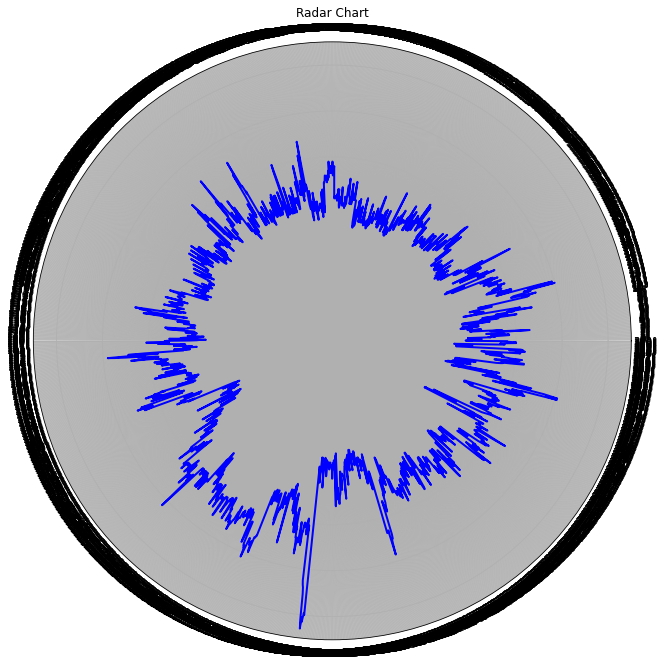

In [143]:
import scipy.stats as stats

# 결과 시각화

# 이차원 리스트를 1차원 리스트로 평탄화
flattened_data = [item for sublist in continuity_check_max_11_total_11 for item in sublist]

# 데이터 시각화 그래프 사이즈 설정
plt.figure(figsize=(22, 11),facecolor='white')

# Radar Chart 그리기
# 각도 계산
angles = np.linspace(0, 2 * np.pi, len(flattened_data), endpoint=False).tolist()
# 데이터 원형으로 만들기
values = flattened_data + [flattened_data[0]]
angles += angles[:1]

# Radar Chart 설정
ax = plt.subplot(111, polar=True)
ax.fill(angles, values, 'b', alpha=0.25)
ax.plot(angles, values, 'b', linewidth=2)

# 레이블 추가
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
# ax.set_xticklabels(['Label1', 'Label2', 'Label3', 'Label4', 'Label5', 'Label6'])  # 각도 레이블
plt.title('Radar Chart')
plt.show()

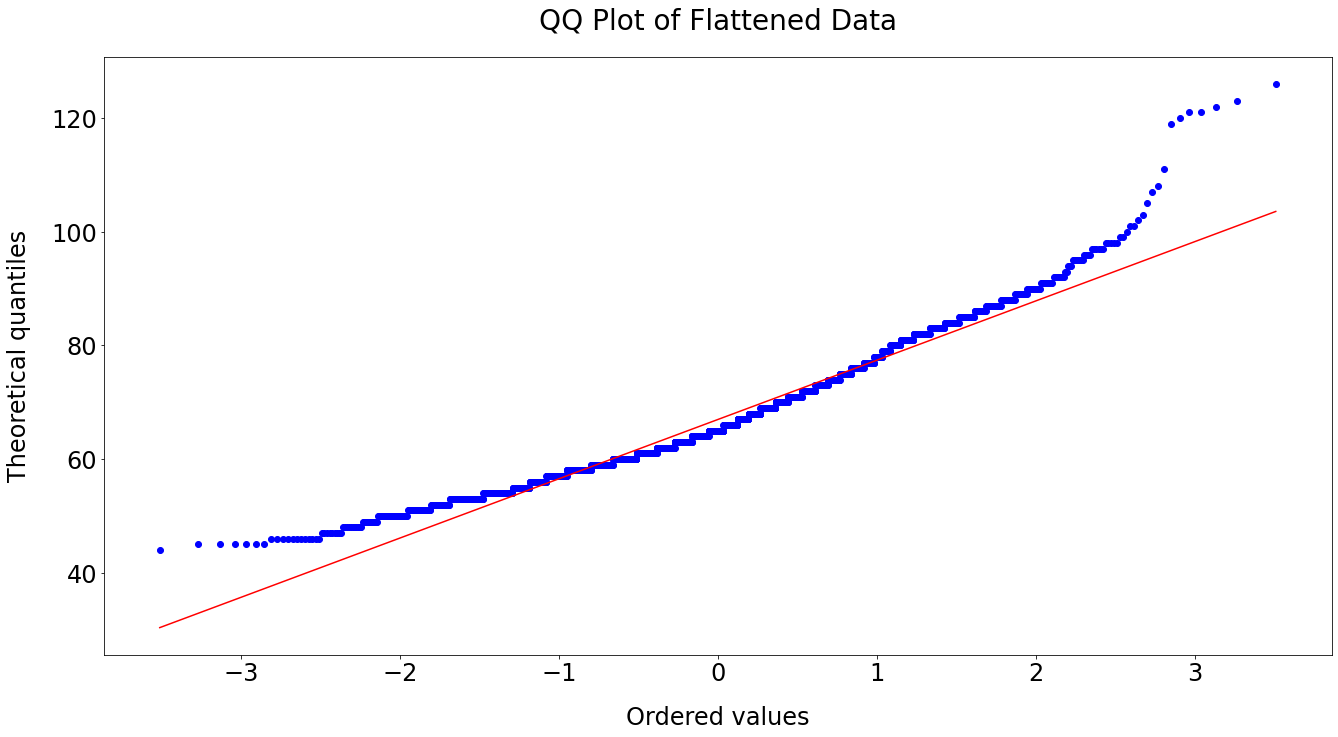

In [144]:
# 데이터 시각화 그래프 사이즈 설정
plt.figure(figsize=(22, 11), facecolor='white')

# QQ 플롯 (정규 분포 확인용)
stats.probplot(flattened_data, dist='norm', plot=plt)
plt.title('QQ Plot of Flattened Data', fontsize=28, pad=28)  # 타이틀 사이즈 설정
plt.xlabel('Ordered values', fontsize=24, labelpad=20)  # X 라벨 폰트 크기 조절
plt.ylabel('Theoretical quantiles', fontsize=24, labelpad=20)  # Y 라벨 폰트 크기 조절

plt.xticks(fontsize=24)  # X 라벨 폰트 크기 설정
plt.yticks(fontsize=24)  # Y 라벨 폰트 크기 설정

plt.show()

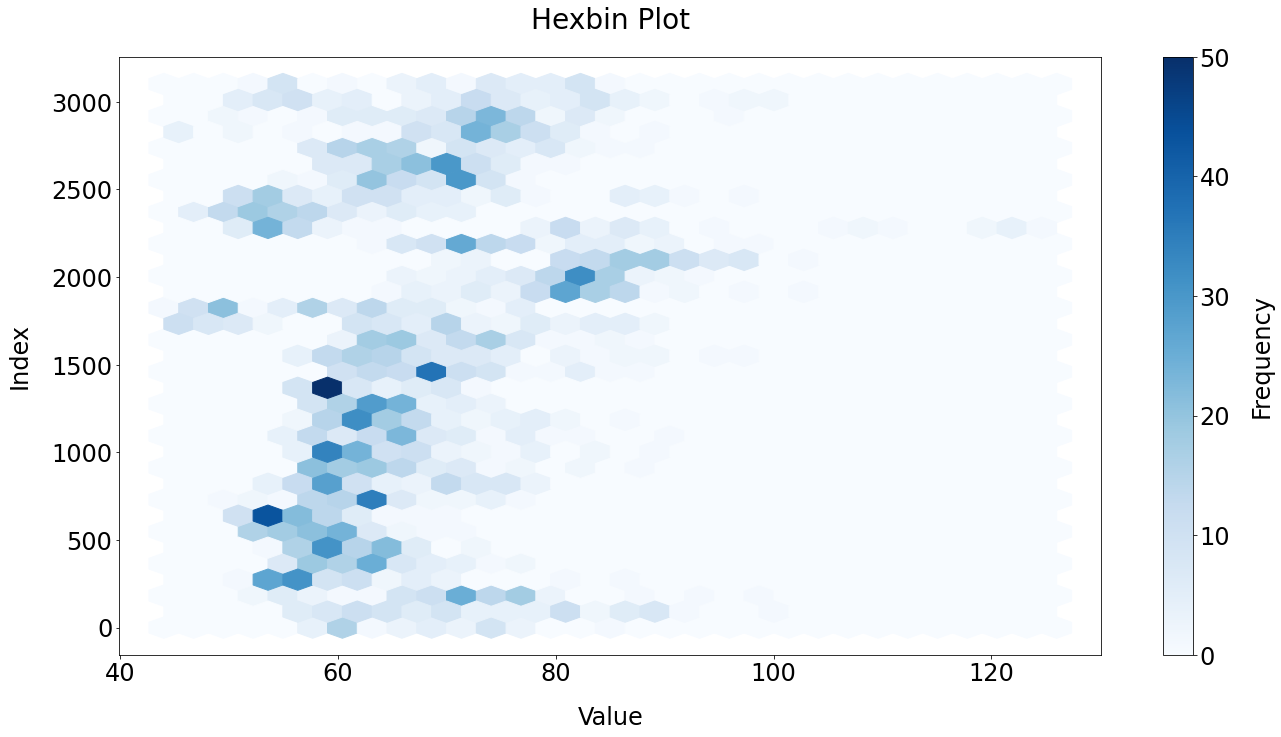

In [145]:
# 데이터 시각화 그래프 사이즈 설정
plt.figure(figsize=(22, 11),facecolor='white')

# Hexbin Plot 그리기
plt.hexbin(flattened_data, range(len(flattened_data)), gridsize=30, cmap='Blues')

cbar = plt.colorbar()
cbar.ax.set_ylabel('Frequency', fontsize=24, labelpad=20)
cbar.ax.tick_params(labelsize=24)

plt.xlabel('Value', fontsize=24, labelpad=20)
plt.ylabel('Index', fontsize=24, labelpad=20)
plt.title('Hexbin Plot', fontsize=28, pad=28)

plt.xticks(fontsize=24)  # X 라벨 폰트 크기 설정
plt.yticks(fontsize=24)  # Y 라벨 폰트 크기 설정

plt.show()

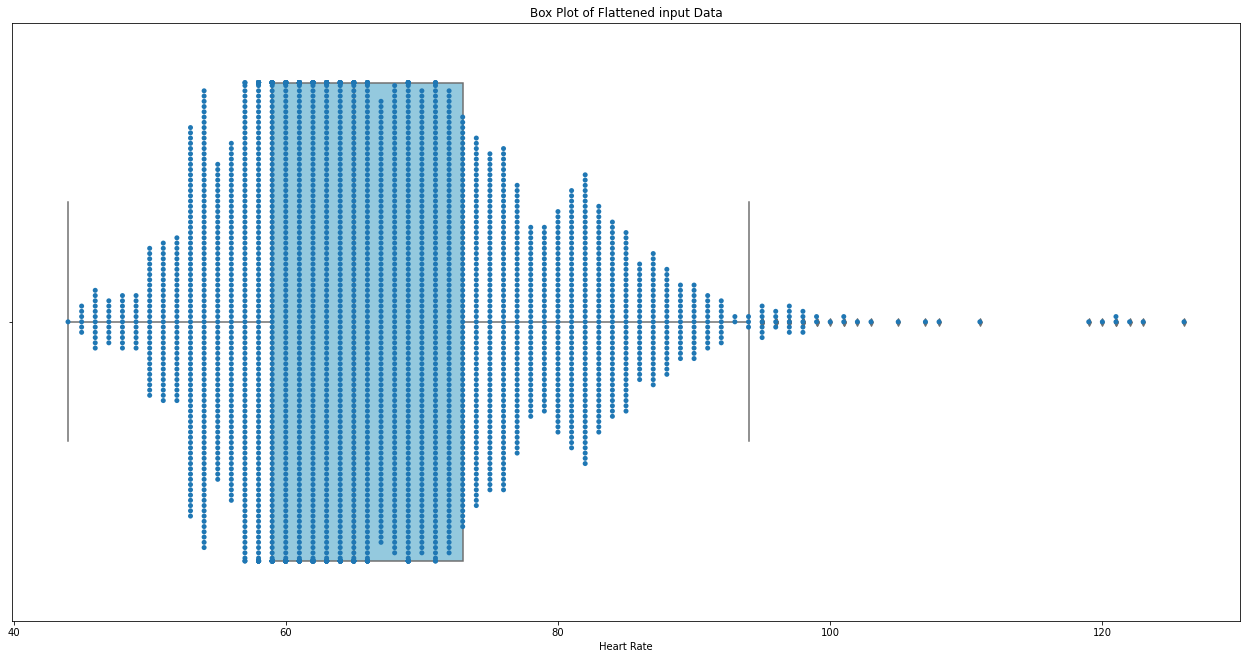

In [146]:
# 데이터 시각화 그래프 사이즈 설정
plt.figure(figsize=(22, 11),facecolor='white')

# 박스 플롯
sns.boxplot(x=flattened_data, color='skyblue')
# Swarm 플롯
sns.swarmplot(flattened_data, label='Original Data')
plt.xlabel('Heart Rate')
plt.title('Box Plot of Flattened input Data')
plt.show()

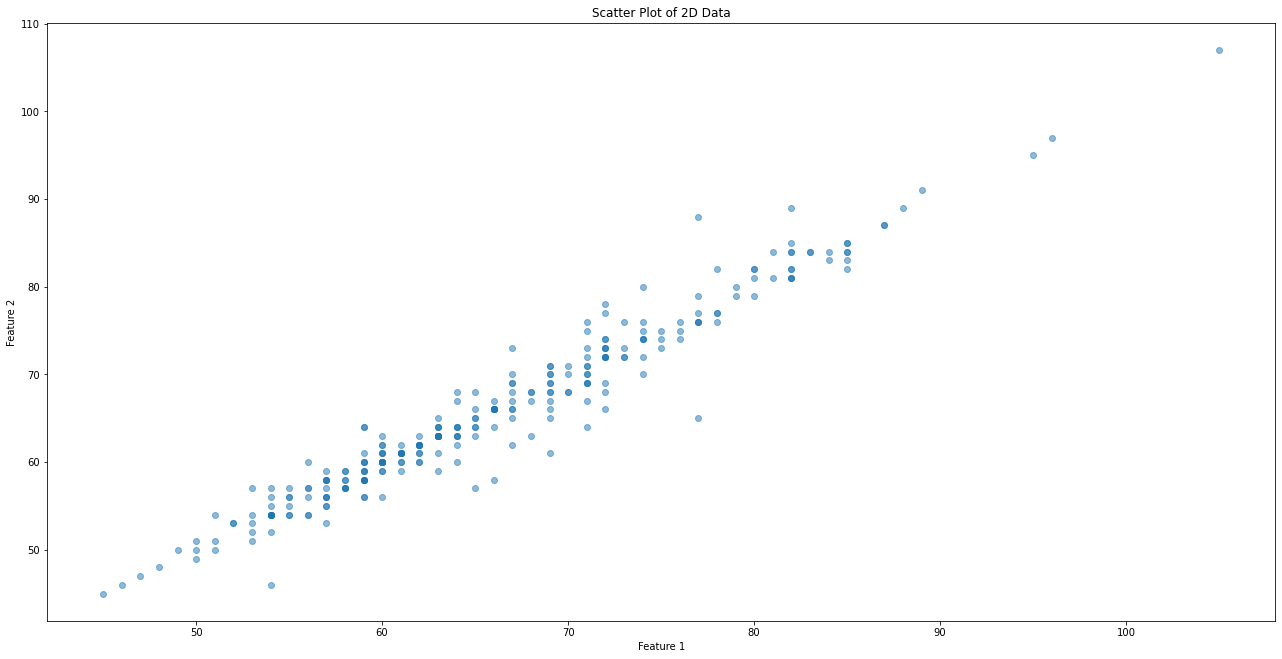

In [147]:
# 2차원 데이터의 산점도를 그려주는 코드. 이를 통해 데이터가 어떻게 분포하는지 시각적으로 확인.

# X와 Y 데이터 추출 : 해당 데이터 사용 안하고 다른 방법으로 데이터 설정
x_data = [item[0] for item in continuity_check_max_11_total_11]
y_data = [item[1] for item in continuity_check_max_11_total_11]

# 오터 인코더 학습 전(인풋) 데이터 확인
# 2D 데이터의 분포 확인 : 2차원 데이터의 0,1 번째 리스트 데이터 2개로만 확인
plt.figure(figsize=(22, 11),facecolor='white')
plt.scatter(array_check_max_11_total_11_np[:, 0], array_check_max_11_total_11_np[:, 1], alpha=0.5)
plt.title("Scatter Plot of 2D Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [148]:
array_check_max_11_total_11_np.shape

(282, 11)

In [149]:
array_check_max_11_total_11_np

array([[59, 58, 61, ..., 59, 60, 59],
       [69, 68, 71, ..., 69, 75, 72],
       [67, 73, 73, ..., 69, 74, 68],
       ...,
       [82, 81, 80, ..., 82, 83, 82],
       [54, 54, 55, ..., 54, 54, 53],
       [75, 75, 74, ..., 77, 76, 76]], dtype=int64)

In [150]:
array_check_max_11_total_11_np[:, 0]

array([ 59,  69,  67,  60,  59,  64,  71,  74,  66,  63,  87,  88,  74,
        71,  77,  72,  73,  56,  72,  69,  66,  66,  61,  56,  57,  57,
        57,  54,  57,  54,  64,  71,  61,  62,  57,  56,  56,  58,  57,
        54,  63,  64,  72,  59,  58,  65,  60,  60,  55,  54,  51,  57,
        54,  57,  59,  57,  54,  54,  52,  55,  54,  59,  53,  62,  62,
        63,  60,  59,  60,  61,  76,  76,  69,  60,  59,  57,  60,  57,
        69,  64,  66,  62,  62,  59,  59,  62,  63,  60,  59,  60,  61,
        61,  62,  59,  75,  64,  63,  58,  58,  72,  66,  72,  66,  62,
        61,  65,  78,  62,  61,  65,  60,  57,  59,  67,  71,  62,  69,
        65,  63,  61,  63,  58,  58,  58,  59,  60,  60,  67,  67,  69,
        68,  72,  68,  75,  64,  63,  60,  63,  61,  61,  63,  72,  66,
        59,  82,  77,  72,  73,  66,  70,  77,  64,  62,  65,  78,  70,
        77,  65,  71,  46,  47,  50,  49,  54,  50,  59,  61,  60,  63,
        66,  77,  71,  84,  82,  85,  85,  80,  81,  80,  69,  7

In [151]:
array_check_max_11_total_11_np[:, 1]

array([ 58,  68,  73,  61,  61,  60,  73,  72,  58,  63,  87,  89,  80,
        70,  76,  73,  72,  56,  72,  66,  66,  66,  61,  54,  55,  53,
        56,  54,  57,  54,  63,  64,  60,  62,  59,  60,  57,  59,  58,
        57,  64,  64,  66,  60,  58,  57,  60,  60,  56,  55,  54,  55,
        54,  58,  56,  56,  56,  54,  53,  54,  54,  56,  51,  62,  63,
        63,  60,  59,  59,  62,  75,  74,  71,  56,  58,  58,  61,  58,
        67,  64,  66,  61,  62,  58,  58,  60,  64,  60,  64,  59,  61,
        61,  62,  60,  74,  68,  59,  57,  57,  68,  66,  77,  66,  62,
        61,  63,  77,  61,  61,  64,  62,  56,  58,  66,  67,  62,  61,
        65,  63,  61,  64,  57,  58,  59,  60,  60,  60,  69,  69,  69,
        68,  69,  68,  73,  67,  63,  60,  63,  60,  61,  65,  73,  64,
        64,  89,  76,  72,  72,  66,  68,  65,  63,  60,  64,  76,  71,
        88,  65,  71,  46,  47,  51,  50,  46,  49,  59,  59,  62,  61,
        67,  77,  72,  83,  82,  84,  85,  79,  81,  82,  70,  7

In [152]:
# 통계적인 방법 중 하나는 샤피로-위키 검정(Shapiro-Wilk test)을 사용. 이 검정은 데이터가 정규분포를 따르는지 확인하는데 사용.
# 이 검정의 귀무가설은 "데이터가 정규분포를 따른다". 
# p-value가 일반적으로 0.05보다 크면 귀무가설을 채택하여 정규분포를 따른다고 판단.
 
from scipy.stats import shapiro

# 첫 번째 feature의 정규성 검정
stat, p_value = shapiro(array_check_max_11_total_11_np[:, 0])
print(f"Shapiro-Wilk Statistic: {stat}, p-value: {p_value}")

# 두 번째 feature의 정규성 검정
stat, p_value = shapiro(array_check_max_11_total_11_np[:, 1])
print(f"Shapiro-Wilk Statistic: {stat}, p-value: {p_value}")

# 전체 feature의 정규성 검정
stat, p_value = shapiro(array_check_max_11_total_11_np)
print(f"Shapiro-Wilk Statistic: {stat}, p-value: {p_value}")


Shapiro-Wilk Statistic: 0.9708496332168579, p-value: 1.6932161088334396e-05
Shapiro-Wilk Statistic: 0.9631717801094055, p-value: 1.3464305084198713e-06
Shapiro-Wilk Statistic: 0.9602856040000916, p-value: 2.379074056541088e-28


In [153]:
# 표준분포 : 표준화(Standardization)는 데이터의 평균을 0, 표준편차를 1로 만들어주는 과정

from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

# 데이터 표준화
scaled_data = scaler.fit_transform(array_check_max_11_total_11_np)
scaled_data


array([[-0.71350731, -0.77943213, -0.4940768 , ..., -0.68636987,
        -0.60118656, -0.66205429],
       [ 0.30424211,  0.20401244,  0.48642747, ...,  0.26663999,
         0.82747588,  0.58516618],
       [ 0.10069223,  0.69573472,  0.68252833, ...,  0.26663999,
         0.73223172,  0.20140603],
       ...,
       [ 1.62731636,  1.48249038,  1.36888132, ...,  1.50555282,
         1.58942918,  1.54456654],
       [-1.22238202, -1.17280996, -1.08237936, ..., -1.16287481,
        -1.17265153, -1.23769451],
       [ 0.91489177,  0.89242364,  0.78057875, ...,  1.02904789,
         0.92272004,  0.96892632]])

In [154]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# 데이터 전처리
input_data = scaled_data  # 2D 데이터

# 모델 정의
input_dim = input_data.shape[1]  # 입력 차원
encoding_dim = 10  # 잠재 공간 차원

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)

autoencoder = Model(input_layer, decoder)

# 모델 컴파일
autoencoder.compile(optimizer='adam', loss='mse')

# 모델 훈련
autoencoder.fit(input_data, input_data, epochs=50, batch_size=1, shuffle=True, validation_split=0.2)

# 재구성된 결과 얻기
reconstructed_data = autoencoder.predict(input_data)
reconstructed_data

Epoch 1/50
225/225 [==============================] - 0s 598us/step - loss: 1.2700 - val_loss: 0.5099
Epoch 2/50
225/225 [==============================] - 0s 415us/step - loss: 0.8800 - val_loss: 0.3769
Epoch 3/50
225/225 [==============================] - 0s 415us/step - loss: 0.7183 - val_loss: 0.3341
Epoch 4/50
225/225 [==============================] - 0s 411us/step - loss: 0.6724 - val_loss: 0.3191
Epoch 5/50
225/225 [==============================] - 0s 424us/step - loss: 0.6567 - val_loss: 0.3112
Epoch 6/50
225/225 [==============================] - 0s 411us/step - loss: 0.6489 - val_loss: 0.3056
Epoch 7/50
225/225 [==============================] - 0s 424us/step - loss: 0.6439 - val_loss: 0.3015
Epoch 8/50
225/225 [==============================] - 0s 406us/step - loss: 0.6404 - val_loss: 0.2976
Epoch 9/50
225/225 [==============================] - 0s 411us/step - loss: 0.6377 - val_loss: 0.2942
Epoch 10/50
225/225 [==============================] - 0s 411us/step - loss: 0.635

array([[1.8989099e-06, 7.2548772e-08, 1.0343091e-07, ..., 2.3429943e-06,
        6.2925042e-06, 6.9588729e-08],
       [5.0031734e-01, 4.9953559e-01, 3.5740477e-01, ..., 5.3001851e-01,
        7.6297951e-01, 6.5757358e-01],
       [4.4913954e-01, 5.5582887e-01, 6.3790697e-01, ..., 6.2860274e-01,
        7.2676474e-01, 6.3615072e-01],
       ...,
       [9.9154735e-01, 9.9552679e-01, 9.9578500e-01, ..., 9.9702817e-01,
        9.9794364e-01, 9.9747133e-01],
       [3.7130019e-10, 3.2909021e-12, 5.4284511e-12, ..., 1.2042960e-09,
        6.8129444e-09, 2.8742876e-12],
       [9.1080886e-01, 9.2722130e-01, 8.7990218e-01, ..., 9.2907381e-01,
        9.5021403e-01, 9.4221616e-01]], dtype=float32)

In [155]:
# 모델 평가
loss = autoencoder.evaluate(input_data, input_data)
print(f'평균 제곱 오차: {loss}')

9/9 [==============================] - 0s 500us/step - loss: 0.5459
평균 제곱 오차: 0.5458818674087524


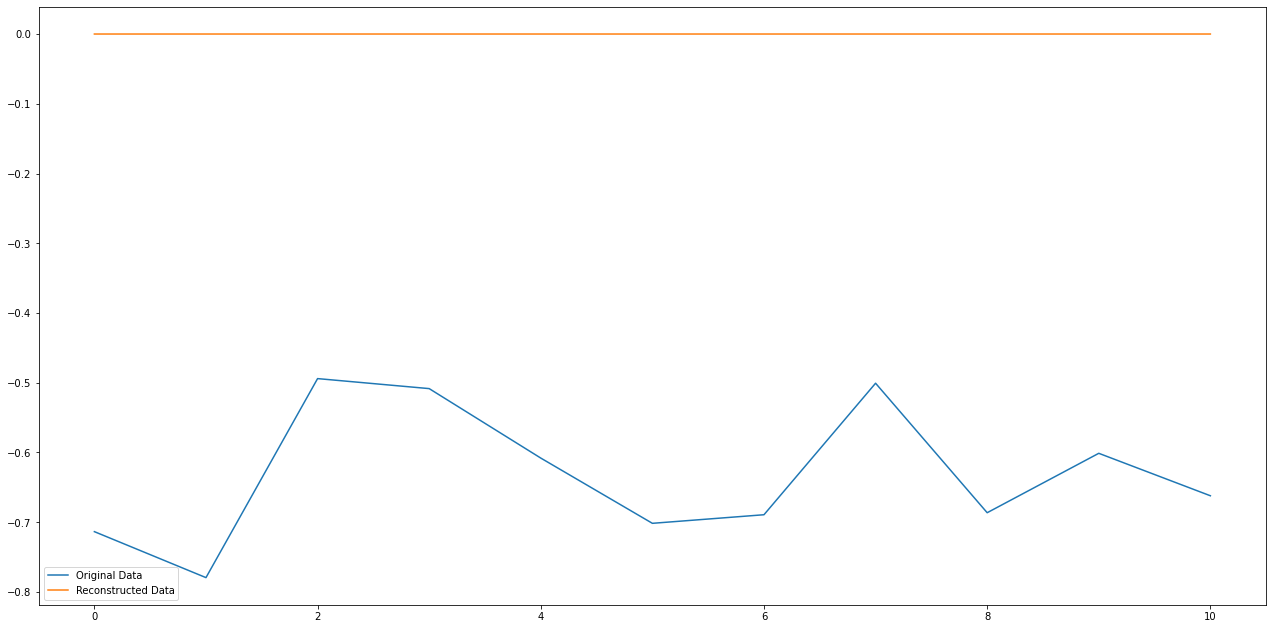

In [156]:

# 재구성된 결과 얻기
reconstructed_data = autoencoder.predict(input_data)

# 결과 시각화
plt.figure(figsize=(22, 11),facecolor='white')
plt.plot(input_data[0], label='Original Data')
plt.plot(reconstructed_data[0], label='Reconstructed Data')
plt.legend()
plt.show()


# MinMaxScaler로 오코인코더

In [157]:
from sklearn.preprocessing import MinMaxScaler

# 스케일러 생성
scaler = MinMaxScaler()

# 데이터를 0과 1 사이로 스케일링
mmscaled_data = scaler.fit_transform(array_check_max_11_total_11_np)

mmscaled_data


array([[0.23333333, 0.20967742, 0.265625  , ..., 0.18421053, 0.19178082,
        0.17567568],
       [0.4       , 0.37096774, 0.421875  , ..., 0.31578947, 0.39726027,
        0.35135135],
       [0.36666667, 0.4516129 , 0.453125  , ..., 0.31578947, 0.38356164,
        0.2972973 ],
       ...,
       [0.61666667, 0.58064516, 0.5625    , ..., 0.48684211, 0.50684932,
        0.48648649],
       [0.15      , 0.14516129, 0.171875  , ..., 0.11842105, 0.10958904,
        0.09459459],
       [0.5       , 0.48387097, 0.46875   , ..., 0.42105263, 0.4109589 ,
        0.40540541]])

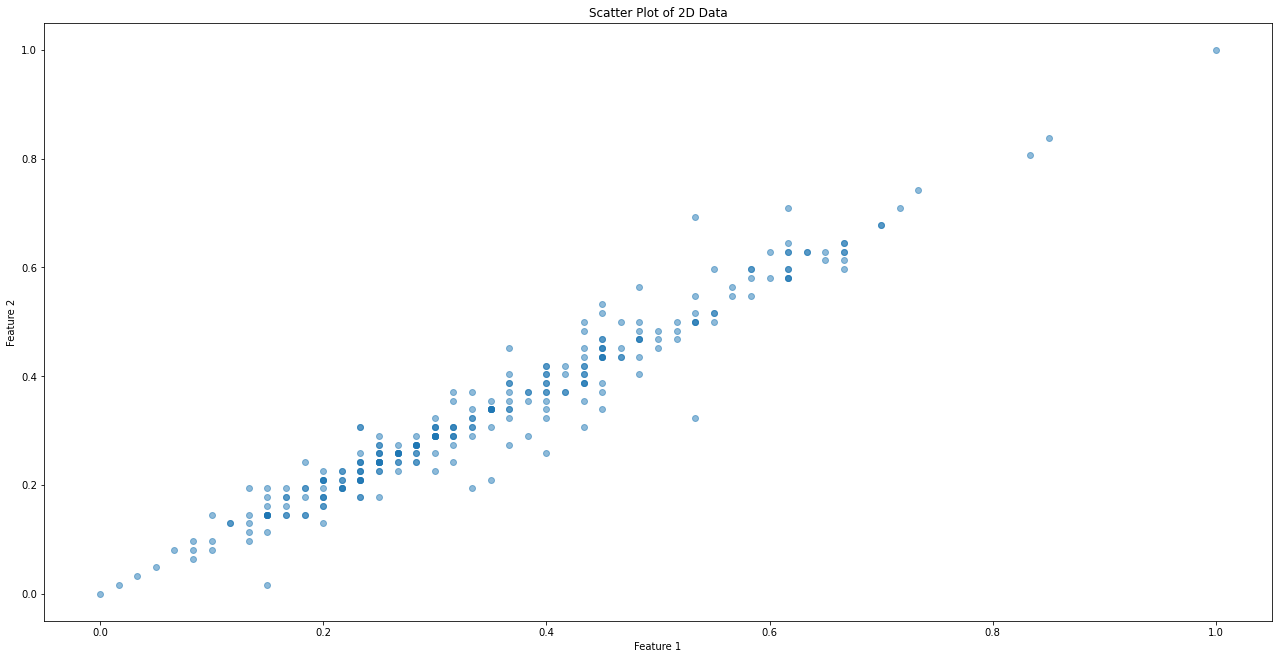

In [158]:
# 오터 인코더 학습 전(인풋) 데이터 확인
# 2D 데이터의 분포 확인 : 2차원 데이터의 0,1 번째 리스트 데이터 2개로만 확인
plt.figure(figsize=(22, 11),facecolor='white')
plt.scatter(mmscaled_data[:, 0], mmscaled_data[:, 1], alpha=0.5)
# plt.scatter(mmscaled_data[:, 0], mmscaled_data[:, -1], alpha=0.5)
# plt.scatter(mmscaled_data[:, :141], mmscaled_data[:, :282], alpha=0.5)
plt.title("Scatter Plot of 2D Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [159]:
# 데이터 전처리
input_data = mmscaled_data  # 2D 데이터

# 모델 정의
input_dim = input_data.shape[1]  # 입력 차원
encoding_dim = 10  # 잠재 공간 차원

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)

autoencoder = Model(input_layer, decoder)

# 모델 컴파일
autoencoder.compile(optimizer='adam', loss='mse')

# 모델 훈련
autoencoder.fit(input_data, input_data, epochs=50, batch_size=1, shuffle=True, validation_split=0.2)

# 재구성된 결과 얻기
reconstructed_data = autoencoder.predict(input_data)
reconstructed_data

Epoch 1/50
225/225 [==============================] - 0s 576us/step - loss: 0.0545 - val_loss: 0.0219
Epoch 2/50
225/225 [==============================] - 0s 415us/step - loss: 0.0401 - val_loss: 0.0181
Epoch 3/50
225/225 [==============================] - 0s 406us/step - loss: 0.0331 - val_loss: 0.0154
Epoch 4/50
225/225 [==============================] - 0s 406us/step - loss: 0.0256 - val_loss: 0.0117
Epoch 5/50
225/225 [==============================] - 0s 406us/step - loss: 0.0180 - val_loss: 0.0077
Epoch 6/50
225/225 [==============================] - 0s 411us/step - loss: 0.0116 - val_loss: 0.0050
Epoch 7/50
225/225 [==============================] - 0s 424us/step - loss: 0.0069 - val_loss: 0.0035
Epoch 8/50
225/225 [==============================] - 0s 416us/step - loss: 0.0043 - val_loss: 0.0024
Epoch 9/50
225/225 [==============================] - 0s 415us/step - loss: 0.0029 - val_loss: 0.0019
Epoch 10/50
225/225 [==============================] - 0s 402us/step - loss: 0.002

array([[0.2521909 , 0.23919713, 0.24701837, ..., 0.19903105, 0.19414246,
        0.18707341],
       [0.4247988 , 0.41606435, 0.41889635, ..., 0.3374214 , 0.33585024,
        0.32677007],
       [0.4424084 , 0.4403543 , 0.4443075 , ..., 0.3512357 , 0.35703936,
        0.34419036],
       ...,
       [0.58967507, 0.588752  , 0.57728547, ..., 0.475239  , 0.46879986,
        0.46202806],
       [0.15382141, 0.14754987, 0.15735012, ..., 0.11660722, 0.10477868,
        0.10042307],
       [0.49511707, 0.4808785 , 0.48440152, ..., 0.39667553, 0.39384094,
        0.3872179 ]], dtype=float32)

In [160]:
reconstructed_data.shape

(282, 11)

In [161]:
# 모델 평가
loss = autoencoder.evaluate(input_data, input_data)
print(f'평균 제곱 오차: {loss}')

9/9 [==============================] - 0s 500us/step - loss: 0.0010
평균 제곱 오차: 0.001049045822583139


In [162]:
# 임계치 설정
threshold = 0.002

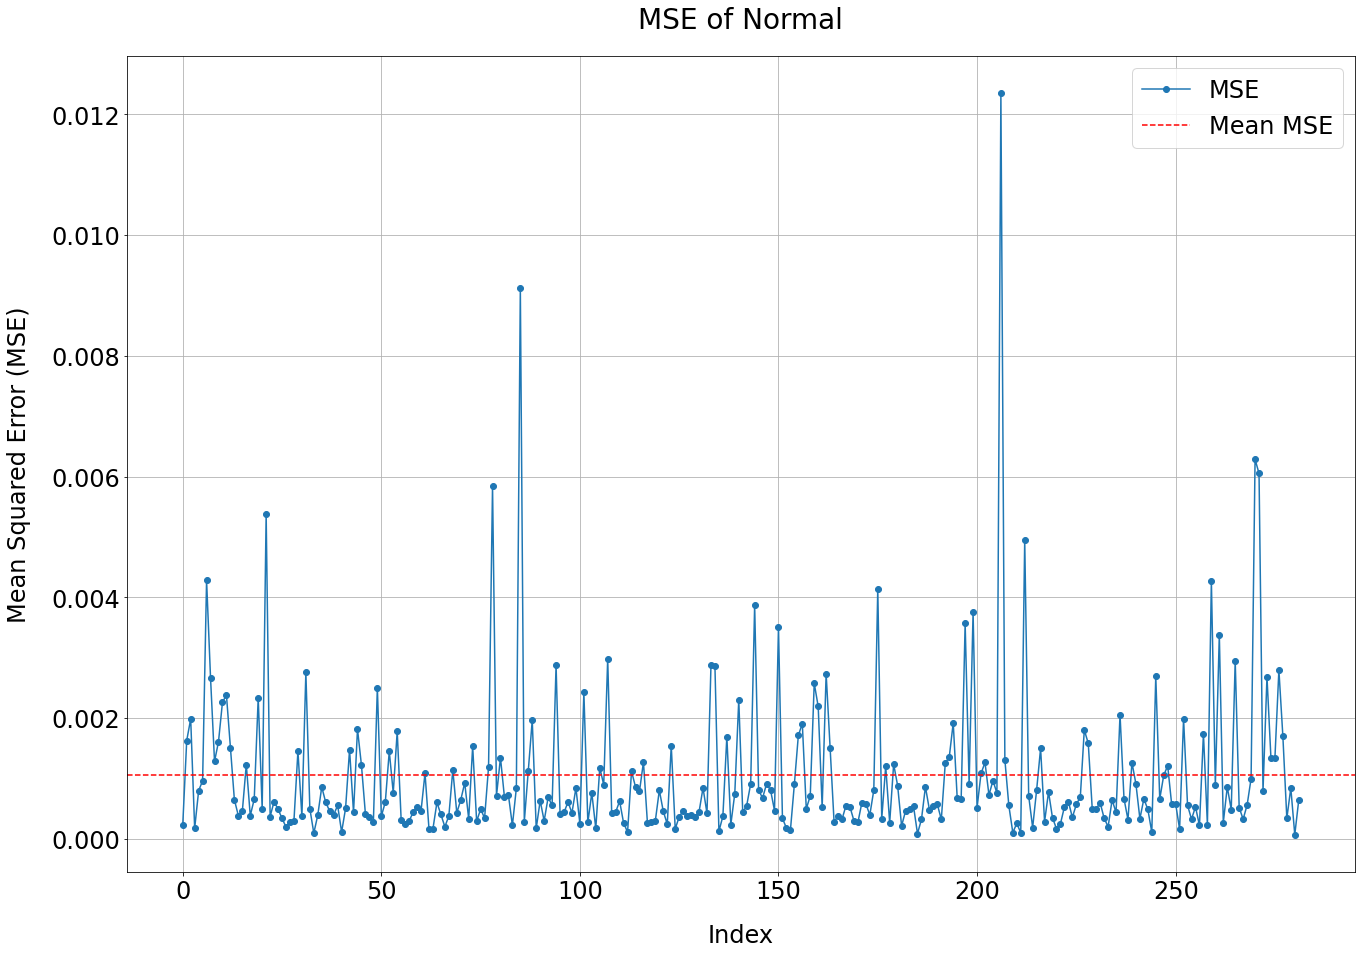

Mean_MSE = 0.001049045855712388
mse_values = [0.00022966855840641492, 0.0016278118068649365, 0.0019852645152664988, 0.00017206589297092184, 0.0007952743209065663, 0.0009617820345956141, 0.004281145474435558, 0.002661908986189699, 0.0012808826029264758, 0.0016069118450595067, 0.0022620579806403238, 0.0023816931170825696, 0.001502810992066695, 0.0006474720379386834, 0.00038281541754893347, 0.00045427780765282635, 0.0012292877035790623, 0.00038249660209751515, 0.0006564982480533273, 0.0023351643730720713, 0.0004965920938439709, 0.005379035127318544, 0.0003686951437577084, 0.000616950710578229, 0.0004891862447605573, 0.000338469162056821, 0.00019470281248494545, 0.00028290373410218457, 0.00029996012150115684, 0.0014516930935753404, 0.00037029199857506473, 0.0027561231783156896, 0.0004999206175613279, 9.327643136795329e-05, 0.00039206011007508534, 0.0008584082168532622, 0.000602177965180449, 0.00045845651113231756, 0.0003970856908544618, 0.0005522003497093774, 0.00011122531366056396, 0.0005

In [163]:
from sklearn.metrics import mean_squared_error
# test_data와 decoded_data의 MSE 값을 계산하여 저장
mse_values = [mean_squared_error(test_seq, decoded_seq) for test_seq, decoded_seq in zip(input_data, reconstructed_data)]

# 각 데이터에 대한 MSE 값을 그래프로 시각화
plt.figure(figsize=(22, 15),facecolor='white')
plt.plot(np.arange(len(mse_values)), mse_values, marker='o', linestyle='-', label='MSE')
plt.axhline(np.mean(mse_values), color='red', linestyle='--', label='Mean MSE')
# plt.axhline(np.mean(threshold), color='red', linestyle='--', label='Threshold')

plt.xlabel('Index', fontsize=24, labelpad=20)
plt.ylabel('Mean Squared Error (MSE)', fontsize=24, labelpad=20)
plt.title('MSE of Normal', fontsize=28, pad=28)
plt.legend(fontsize=24)
plt.grid(True)

plt.xticks(fontsize=24)  # X 라벨 폰트 크기 설정
plt.yticks(fontsize=24)  # Y 라벨 폰트 크기 설정

plt.show()

print('Mean_MSE =', np.mean(mse_values))
print('mse_values =', mse_values)

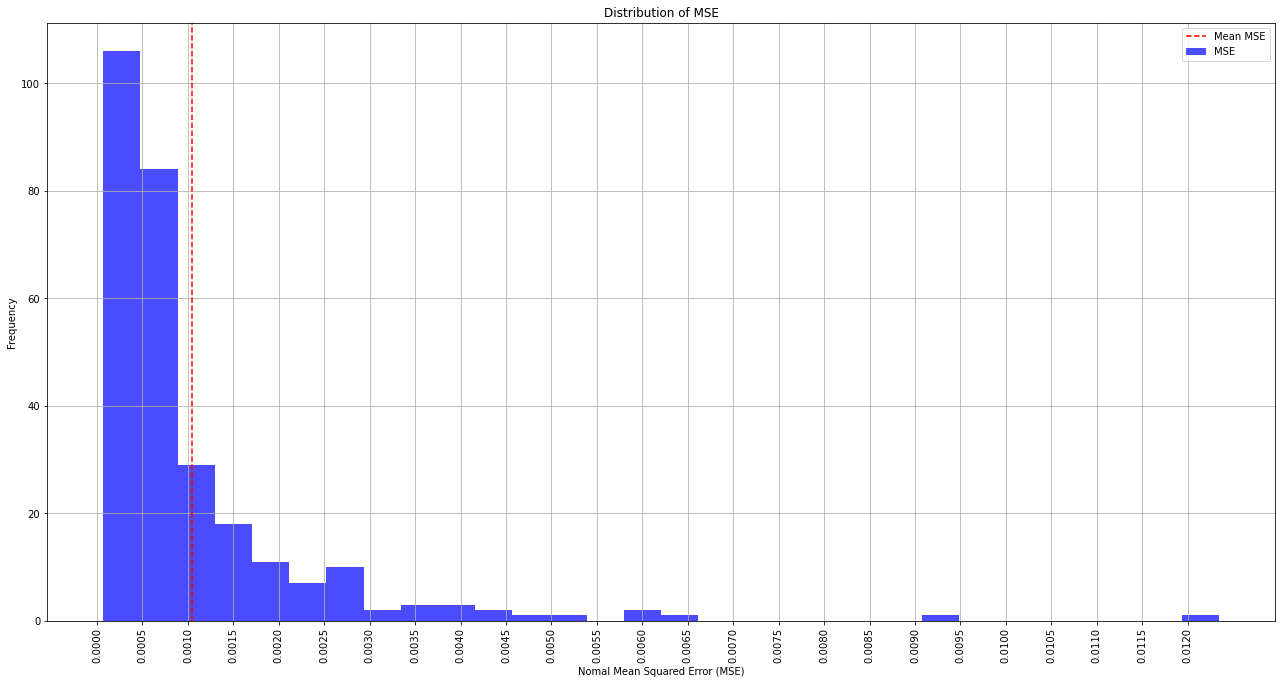

In [164]:

# MSE 값의 분포를 히스토그램으로 표시
plt.figure(figsize=(22, 11),facecolor='white')
plt.hist(mse_values, bins=30, color='blue', alpha=0.7, label='MSE')
plt.axvline(np.mean(mse_values), color='red', linestyle='--', label='Mean MSE')
plt.xlabel('Nomal Mean Squared Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of MSE')
plt.legend()
plt.grid(True)

# x 축 눈금 설정
plt.xticks(np.arange(0, max(mse_values), 0.0005), rotation=90)

plt.show()

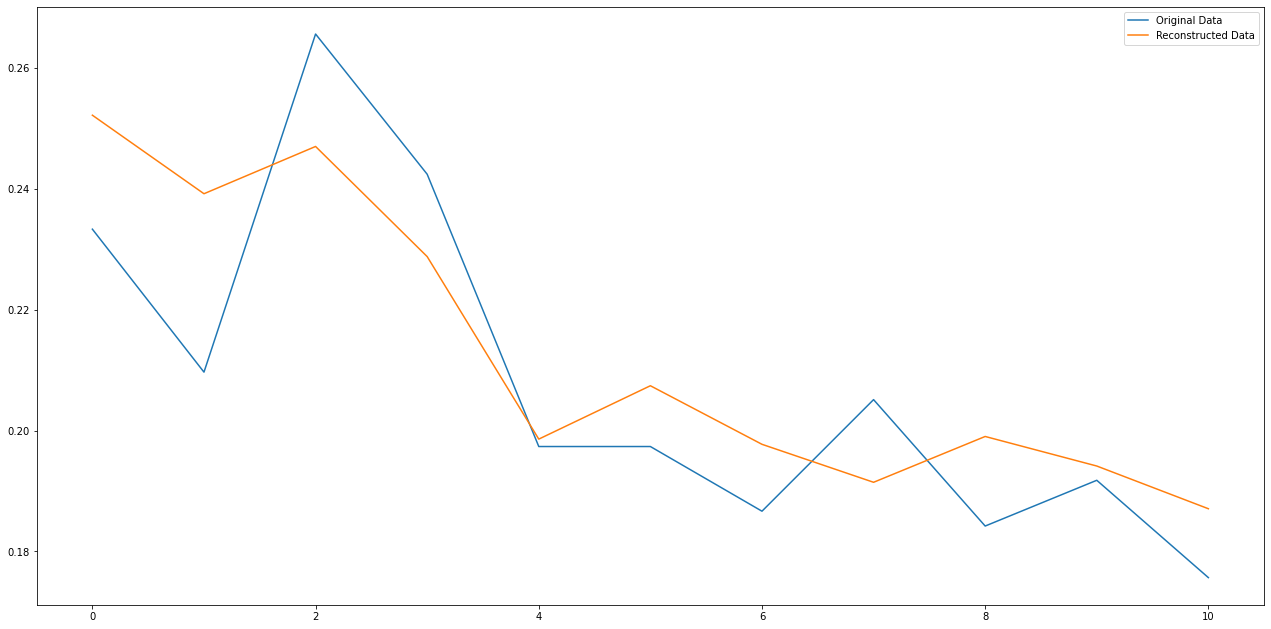

In [165]:

# 재구성된 결과 시각화
plt.figure(figsize=(22, 11),facecolor='white')
plt.plot(input_data[0], label='Original Data')
plt.plot(reconstructed_data[0], label='Reconstructed Data')
plt.legend()
plt.show()

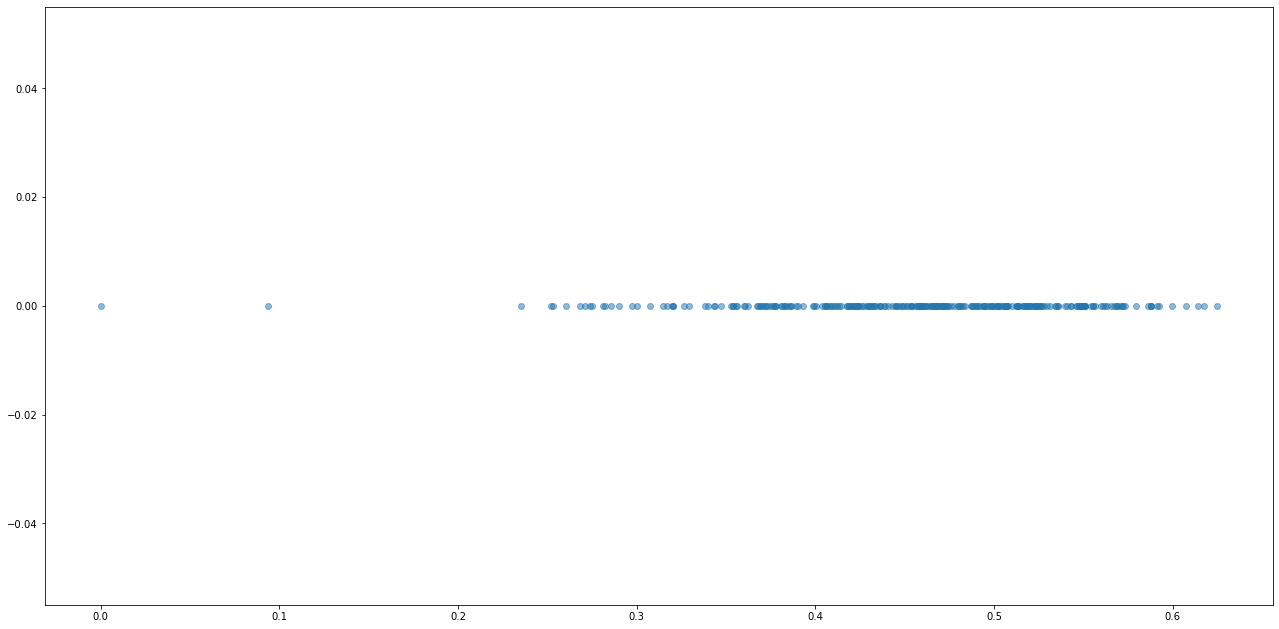

In [166]:
# 인코더 모델 생성
encoder_model = Model(input_layer, encoder)

# 오터인코더 학습 후 인풋데이터가 인코딩된 데이터 확인
# 2D 데이터의 분포 확인 : 2차원 데이터의 0,1 번째 리스트 데이터 2개로만 확인
plt.figure(figsize=(22, 11),facecolor='white')
encoded_data = encoder_model.predict(input_data)
plt.scatter(encoded_data[:, 1], encoded_data[:, 2], alpha=0.5)
plt.show()

In [167]:
encoded_data.shape

(282, 10)

In [168]:
encoded_data

array([[0.7914777 , 0.5070347 , 0.        , ..., 0.        , 0.        ,
        0.72523814],
       [1.6008773 , 0.40548888, 0.        , ..., 0.        , 0.        ,
        0.576893  ],
       [1.7348189 , 0.40897825, 0.        , ..., 0.        , 0.        ,
        0.5504318 ],
       ...,
       [2.2978427 , 0.38356972, 0.        , ..., 0.        , 0.        ,
        0.46811822],
       [0.40609914, 0.5495045 , 0.        , ..., 0.        , 0.        ,
        0.777612  ],
       [1.8863747 , 0.3293614 , 0.        , ..., 0.        , 0.        ,
        0.54227746]], dtype=float32)

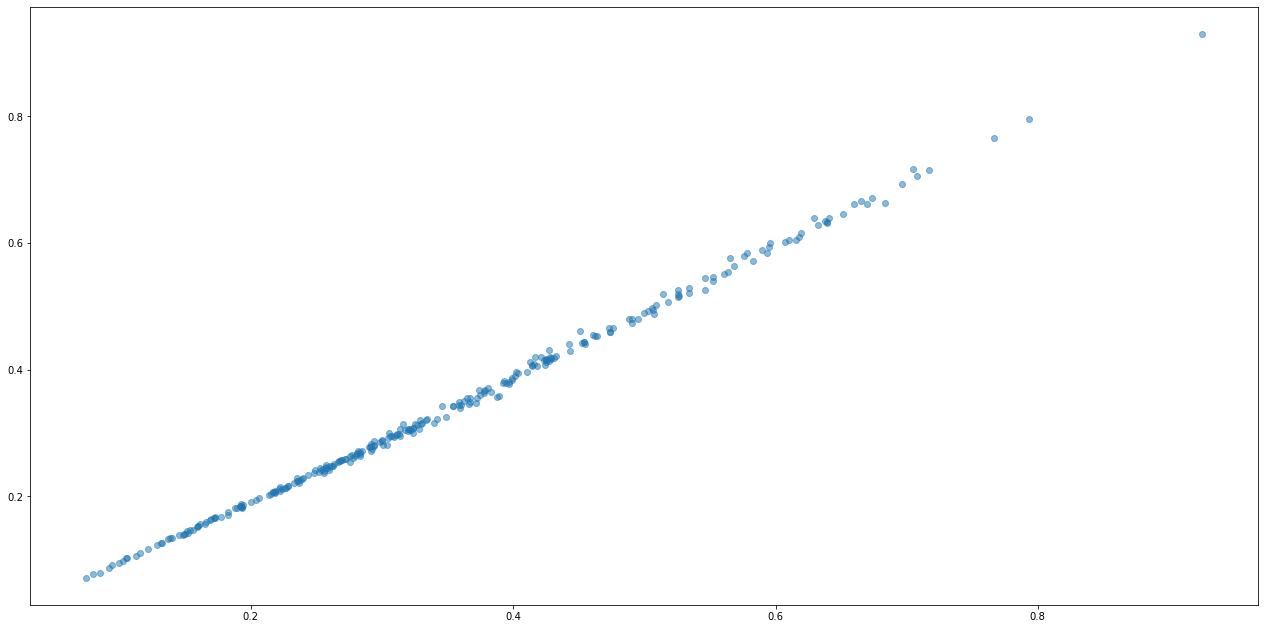

In [169]:

# 오터인코더 학습 후 디코딩된(아웃풋) 데이터 확인
# 2D 데이터의 분포 확인 : 2차원 데이터의 0,1 번째 리스트 데이터 2개로만 확인
plt.figure(figsize=(22, 11),facecolor='white')
plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], alpha=0.5)
plt.show()



In [170]:
reconstructed_data

array([[0.2521909 , 0.23919713, 0.24701837, ..., 0.19903105, 0.19414246,
        0.18707341],
       [0.4247988 , 0.41606435, 0.41889635, ..., 0.3374214 , 0.33585024,
        0.32677007],
       [0.4424084 , 0.4403543 , 0.4443075 , ..., 0.3512357 , 0.35703936,
        0.34419036],
       ...,
       [0.58967507, 0.588752  , 0.57728547, ..., 0.475239  , 0.46879986,
        0.46202806],
       [0.15382141, 0.14754987, 0.15735012, ..., 0.11660722, 0.10477868,
        0.10042307],
       [0.49511707, 0.4808785 , 0.48440152, ..., 0.39667553, 0.39384094,
        0.3872179 ]], dtype=float32)

In [171]:
reconstructed_data.shape

(282, 11)

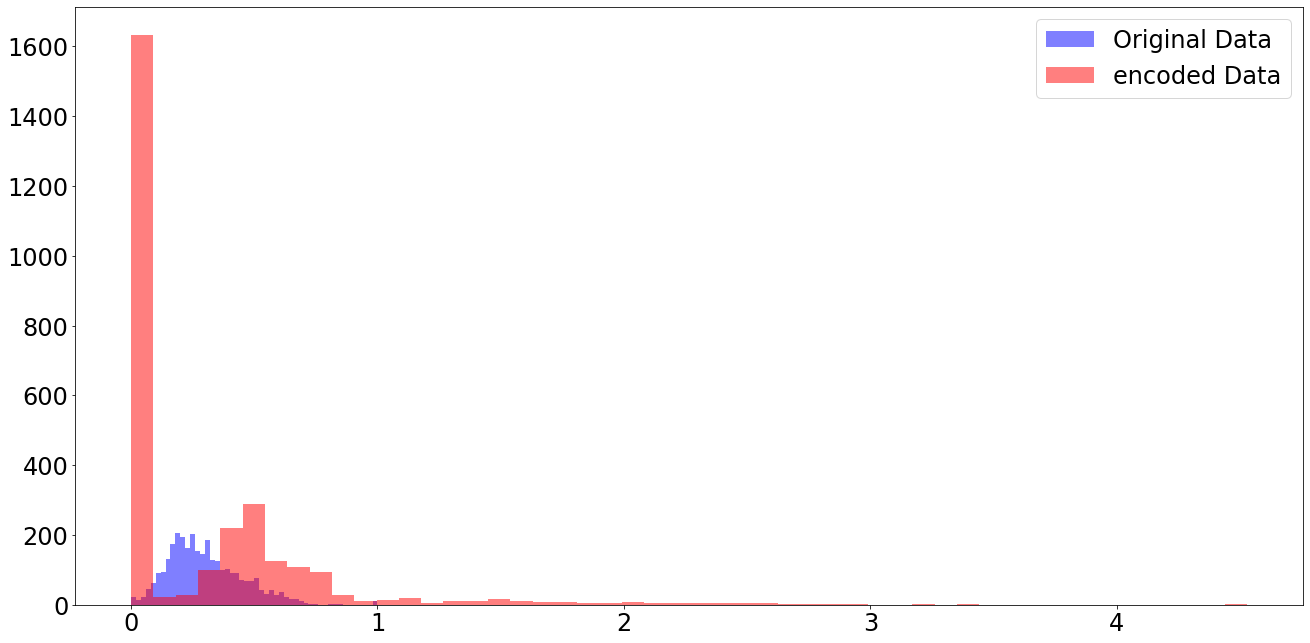

In [172]:
# 인풋데이터와 인코딩된 데이터 비교 확인 그래프
# 인코딩된 데이터는 분류 작업을 위한 특성으로 사용될 수 있다.

plt.figure(figsize=(22, 11),facecolor='white')
plt.hist(input_data.flatten(), bins=50, alpha=0.5, color='blue', label='Original Data')
plt.hist(encoded_data.flatten(), bins=50, alpha=0.5, color='red', label='encoded Data')

plt.legend(fontsize=24)
# plt.grid(True)

plt.xticks(fontsize=24)  # X 라벨 폰트 크기 설정
plt.yticks(fontsize=24)  # Y 라벨 폰트 크기 설정

plt.legend(fontsize=24)
plt.show()

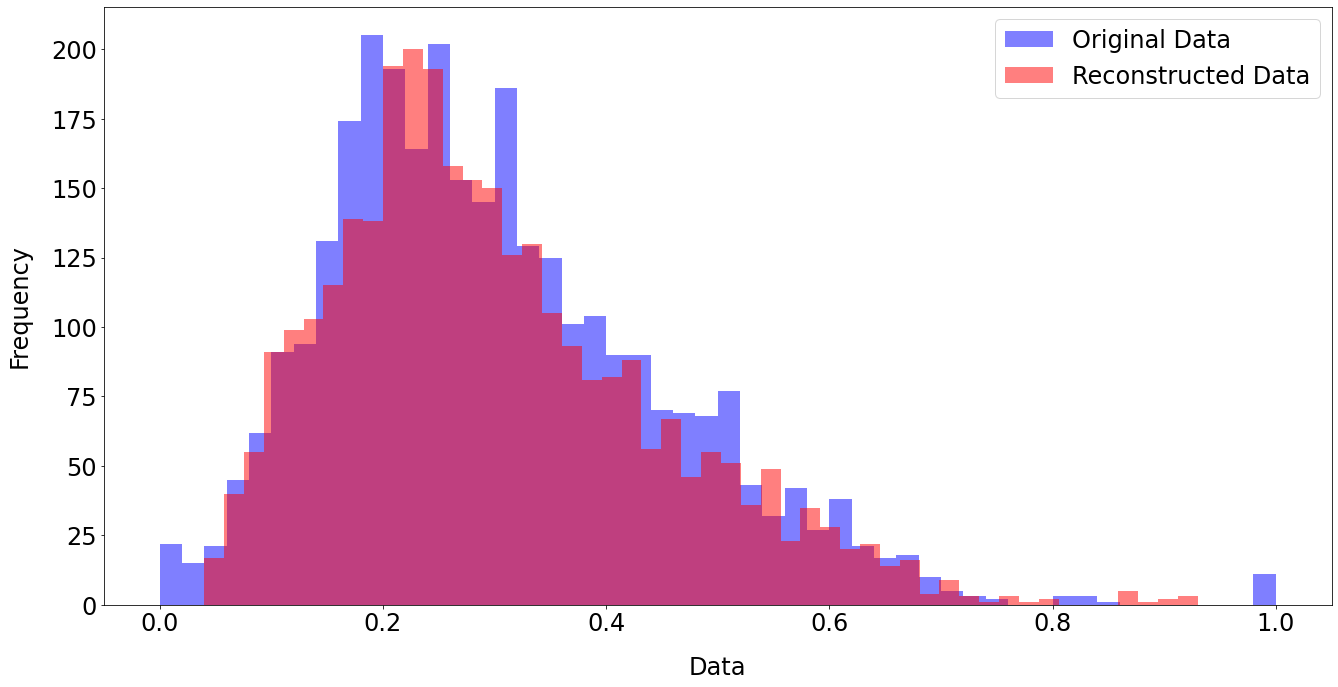

In [173]:
# 인풋데이터와 디코딩된 데이터 비교 확인 히스토그램 그래프

plt.figure(figsize=(22, 11),facecolor='white')
plt.hist(input_data.flatten(), bins=50, alpha=0.5, color='blue', label='Original Data')
plt.hist(reconstructed_data.flatten(), bins=50, alpha=0.5, color='red', label='Reconstructed Data')

plt.xlabel('Data', fontsize=24, labelpad=20)
plt.ylabel('Frequency', fontsize=24, labelpad=20)

plt.xticks(fontsize=24)  # X 라벨 폰트 크기 설정
plt.yticks(fontsize=24)  # Y 라벨 폰트 크기 설정
plt.legend(fontsize=24)

plt.show()


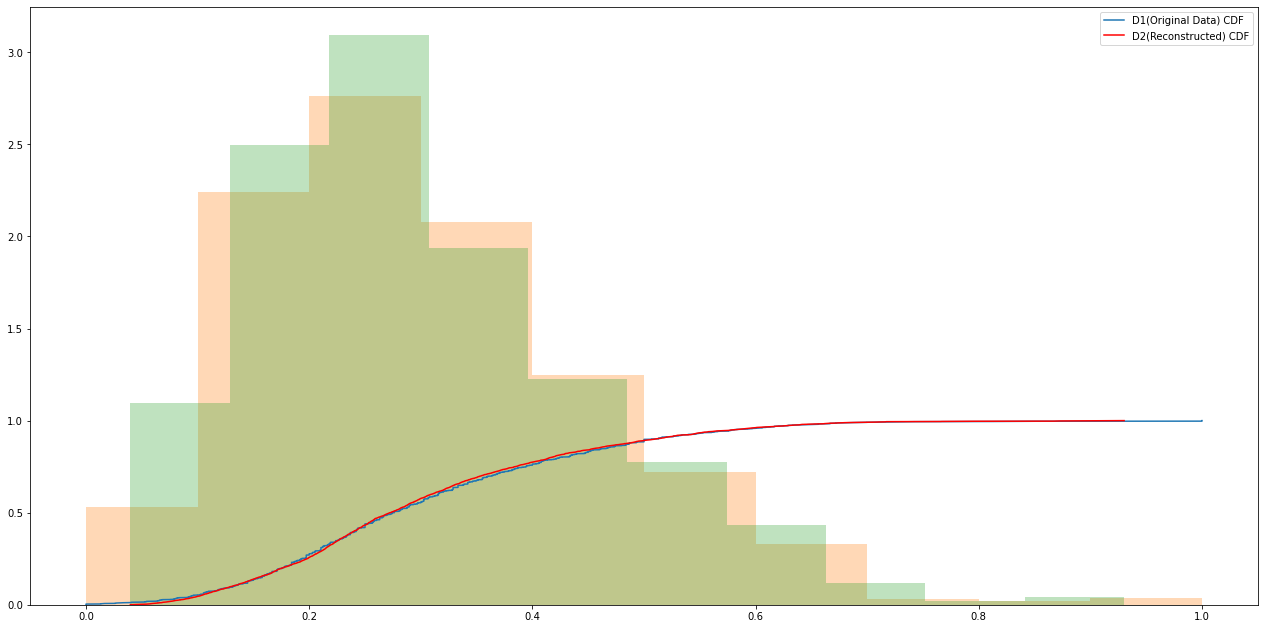

In [174]:
# 인풋데이터와 디코딩된 데이터 비교 확인 히스토그램 그래프에 CDF(누적 분포 함수) 추가
# 빈(Bin) 크기를 변경할 때 구조가 변경될 수 있고 각 빈에는 통계적 불확실성이 존재 할 수 있어 CDF 확인
# Empirical 경험적 Cumulative 누적 Distribution 분포 Functions 함수

d1 = input_data.flatten()
d2 = reconstructed_data.flatten()
sd1 = np.sort(d1)
sd2 = np.sort(d2)
cdf = np.linspace(1/d1.size, 1, d1.size)

plt.figure(figsize=(22, 11), facecolor='white')
plt.plot(sd1, cdf, label="D1(Original Data) CDF")
plt.plot(sd2, cdf, color = "red", label="D2(Reconstructed) CDF")
plt.hist(d1,  density=True, alpha=0.3)
plt.hist(d2,  density=True, alpha=0.3)
plt.legend()
plt.show()

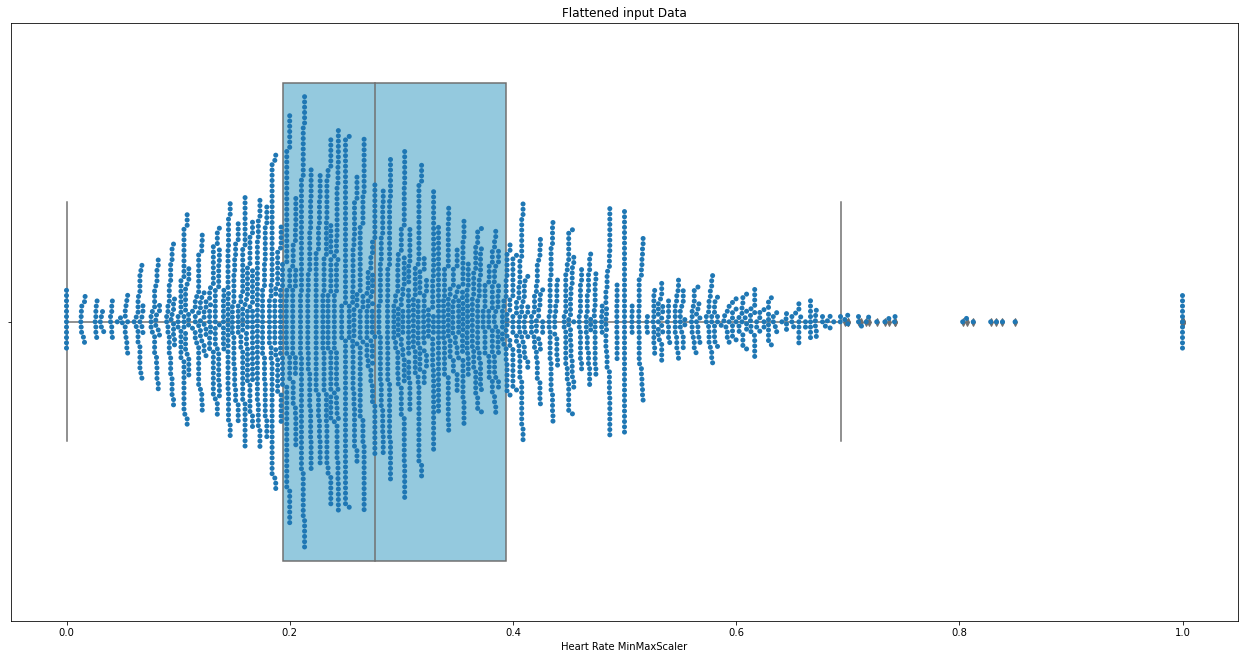

In [175]:

# 인풋데이터 전체 형상을 보기 위한 Box + Swarm Plots

# 데이터 시각화 그래프 사이즈 설정
plt.figure(figsize=(22, 11),facecolor='white')

# Box 플롯
sns.boxplot(x=input_data.flatten(), color='skyblue')
# Swarm 플롯
sns.swarmplot(input_data.flatten(), label='Original Data')
plt.xlabel('Heart Rate MinMaxScaler')
plt.title('Flattened input Data')
plt.show()

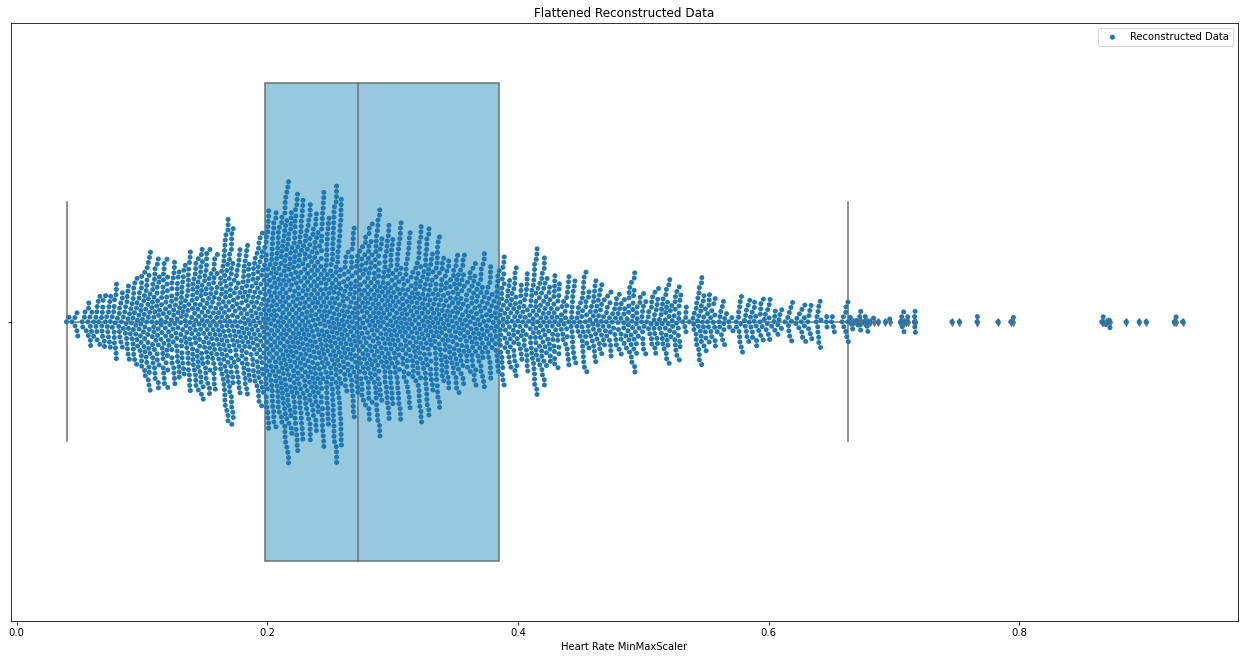

In [176]:
# 디코딩된 데이터 전체 형상을 보기 위한 Box + Swarm Plots

plt.figure(figsize=(22, 11),facecolor='white')
# Box 플롯
sns.boxplot(x=reconstructed_data.flatten(), color='skyblue')
# Swarm 플롯
sns.swarmplot(reconstructed_data.flatten(), label='Reconstructed Data')
plt.xlabel('Heart Rate MinMaxScaler')
plt.title('Flattened Reconstructed Data')
plt.legend()
plt.show()

# 고혈압 데이터 이상치 확인

In [177]:
df_hypertension_early_morning_time_continuity_30_count = df_hypertension_early_morning_time_continuity_30_count.reset_index(drop=True)
df_hypertension_early_morning_time_continuity_30_count

,id,hypertension,measure_time,heart_rate,date,year,month,day,hour,week,time_diff,time_interval,continuity,start,end,rr,continuity1
0,11005,1,2023-03-23 05:29:00,69,2023-03-23,2023,3,23,5,Thursday,0 days 00:01:00,1,1,,,0.869565,1
1,11005,1,2023-03-23 05:30:00,82,2023-03-23,2023,3,23,5,Thursday,0 days 00:01:00,1,2,,,0.731707,2
2,11005,1,2023-03-23 05:31:00,81,2023-03-23,2023,3,23,5,Thursday,0 days 00:01:00,1,3,,,0.740741,3
3,11005,1,2023-03-23 05:32:00,83,2023-03-23,2023,3,23,5,Thursday,0 days 00:01:00,1,4,,,0.722892,4
4,11005,1,2023-03-23 05:33:00,86,2023-03-23,2023,3,23,5,Thursday,0 days 00:01:00,1,5,,,0.697674,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,32089,1,2023-05-09 00:57:00,60,2023-05-09,2023,5,9,0,Tuesday,0 days 00:01:00,1,56,,,1.000000,26
476,32089,1,2023-05-09 00:58:00,60,2023-05-09,2023,5,9,0,Tuesday,0 days 00:01:00,1,57,,,1.000000,27
477,32089,1,2023-05-09 00:59:00,60,2023-05-09,2023,5,9,0,Tuesday,0 days 00:01:00,1,58,,,1.000000,28
478,32089,1,2023-05-09 01:00:00,61,2023-05-09,2023,5,9,1,Tuesday,0 days 00:01:00,1,59,,,0.983607,29


In [178]:
df_tem = df_hypertension_early_morning_time_continuity_30_count

# 연속 데이터 확인 리스트
continuity_check = []

hypertension_continuity_check_max_11_total = []

# 반복문을 통해 값을 입력
for i in range(len(df_tem)):
    
    continuity_check.append(df_tem.at[i, 'heart_rate'])
    
    if (i < len(df_tem)-1) and (df_tem['continuity1'].iloc[i+1] == 1):
        # continuity_check 리스트에서 최대값과 해당 인덱스 찾기
        max_value = max(continuity_check)
        max_index = continuity_check.index(max_value)

        # 최대값을 기준으로 전후 5개씩 추가하기
        continuity_check_max_11 = continuity_check[max_index-5:max_index+6]
        
        hypertension_continuity_check_max_11_total.append(continuity_check_max_11)
        continuity_check = []

hypertension_continuity_check_max_11_total

[[83, 82, 81, 81, 83, 90, 85, 80, 80, 80, 83],
 [57, 57, 56, 61, 68, 75, 73, 73, 67, 66, 68],
 [],
 [],
 [70, 76, 71, 72, 75, 80, 66, 63, 63, 61, 64],
 [99, 99, 100, 100, 100, 101, 100],
 [102, 102, 103, 103, 105, 114, 107, 110, 106, 104, 103],
 [109, 110, 111, 111, 121, 127, 122, 115, 120, 117, 118],
 [],
 [93, 93, 107, 107, 107, 109, 107, 108, 108, 103, 102],
 [104, 103, 111, 104, 104, 120, 110, 102, 100, 104, 107],
 [93, 94, 95, 107, 104, 109, 106, 106, 106, 105, 103],
 [79, 78, 80, 85, 82, 88, 84, 81, 81, 77, 80],
 [62, 62, 64, 68, 67, 70, 64, 66, 62, 59, 63],
 [65, 64, 63, 62, 62, 67, 66, 65, 64, 67, 66]]

In [179]:
hypertension_continuity_check_max_11_total = [item for item in hypertension_continuity_check_max_11_total if len(item) == 11]
print(len(hypertension_continuity_check_max_11_total))
hypertension_continuity_check_max_11_total

11


[[83, 82, 81, 81, 83, 90, 85, 80, 80, 80, 83],
 [57, 57, 56, 61, 68, 75, 73, 73, 67, 66, 68],
 [70, 76, 71, 72, 75, 80, 66, 63, 63, 61, 64],
 [102, 102, 103, 103, 105, 114, 107, 110, 106, 104, 103],
 [109, 110, 111, 111, 121, 127, 122, 115, 120, 117, 118],
 [93, 93, 107, 107, 107, 109, 107, 108, 108, 103, 102],
 [104, 103, 111, 104, 104, 120, 110, 102, 100, 104, 107],
 [93, 94, 95, 107, 104, 109, 106, 106, 106, 105, 103],
 [79, 78, 80, 85, 82, 88, 84, 81, 81, 77, 80],
 [62, 62, 64, 68, 67, 70, 64, 66, 62, 59, 63],
 [65, 64, 63, 62, 62, 67, 66, 65, 64, 67, 66]]

In [180]:
# 리스트를 넘파이 배열로 변환
hypertension_array_check_max_11_total_11_np = np.array(hypertension_continuity_check_max_11_total)

# 배열의 형태 확인
print(hypertension_array_check_max_11_total_11_np.shape)
hypertension_array_check_max_11_total_11_np

(11, 11)


array([[ 83,  82,  81,  81,  83,  90,  85,  80,  80,  80,  83],
       [ 57,  57,  56,  61,  68,  75,  73,  73,  67,  66,  68],
       [ 70,  76,  71,  72,  75,  80,  66,  63,  63,  61,  64],
       [102, 102, 103, 103, 105, 114, 107, 110, 106, 104, 103],
       [109, 110, 111, 111, 121, 127, 122, 115, 120, 117, 118],
       [ 93,  93, 107, 107, 107, 109, 107, 108, 108, 103, 102],
       [104, 103, 111, 104, 104, 120, 110, 102, 100, 104, 107],
       [ 93,  94,  95, 107, 104, 109, 106, 106, 106, 105, 103],
       [ 79,  78,  80,  85,  82,  88,  84,  81,  81,  77,  80],
       [ 62,  62,  64,  68,  67,  70,  64,  66,  62,  59,  63],
       [ 65,  64,  63,  62,  62,  67,  66,  65,  64,  67,  66]],
      dtype=int64)

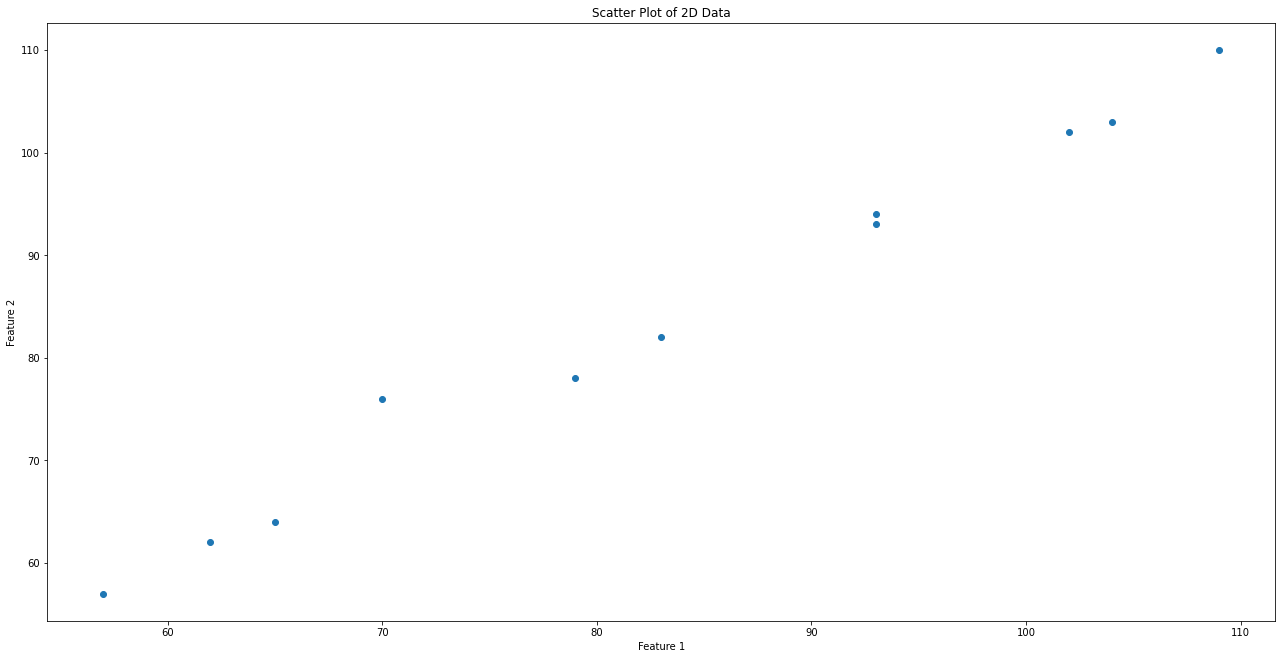

In [181]:
# 2차원 데이터의 산점도 확인. 이를 통해 데이터가 어떻게 분포하는지 시각적으로 확인.
import matplotlib.pyplot as plt

# 2D 데이터의 분포 확인
plt.figure(figsize=(22, 11),facecolor='white')
plt.scatter(hypertension_array_check_max_11_total_11_np[:, 0], hypertension_array_check_max_11_total_11_np[:, 1])
plt.title("Scatter Plot of 2D Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

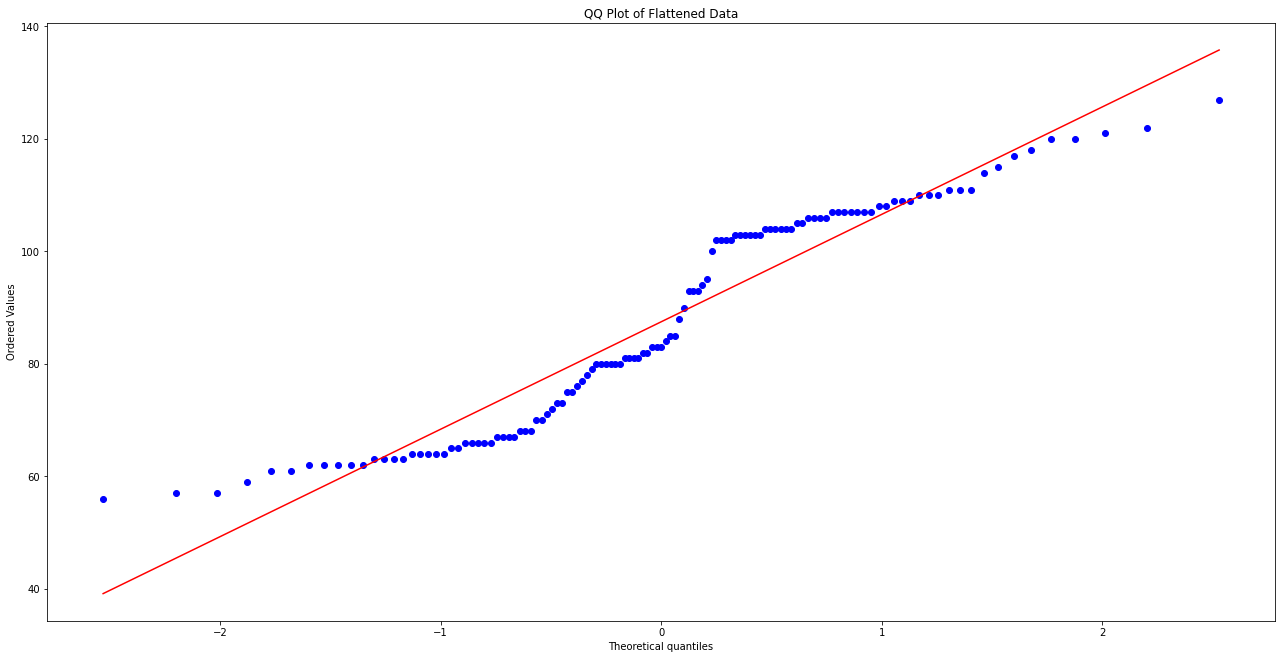

In [182]:
# 데이터 시각화 그래프 사이즈 설정
plt.figure(figsize=(22, 11),facecolor='white')

# QQ 플롯 (정규 분포 확인용)
stats.probplot(hypertension_array_check_max_11_total_11_np.flatten(), dist='norm', plot=plt)
plt.title('QQ Plot of Flattened Data')
plt.show()

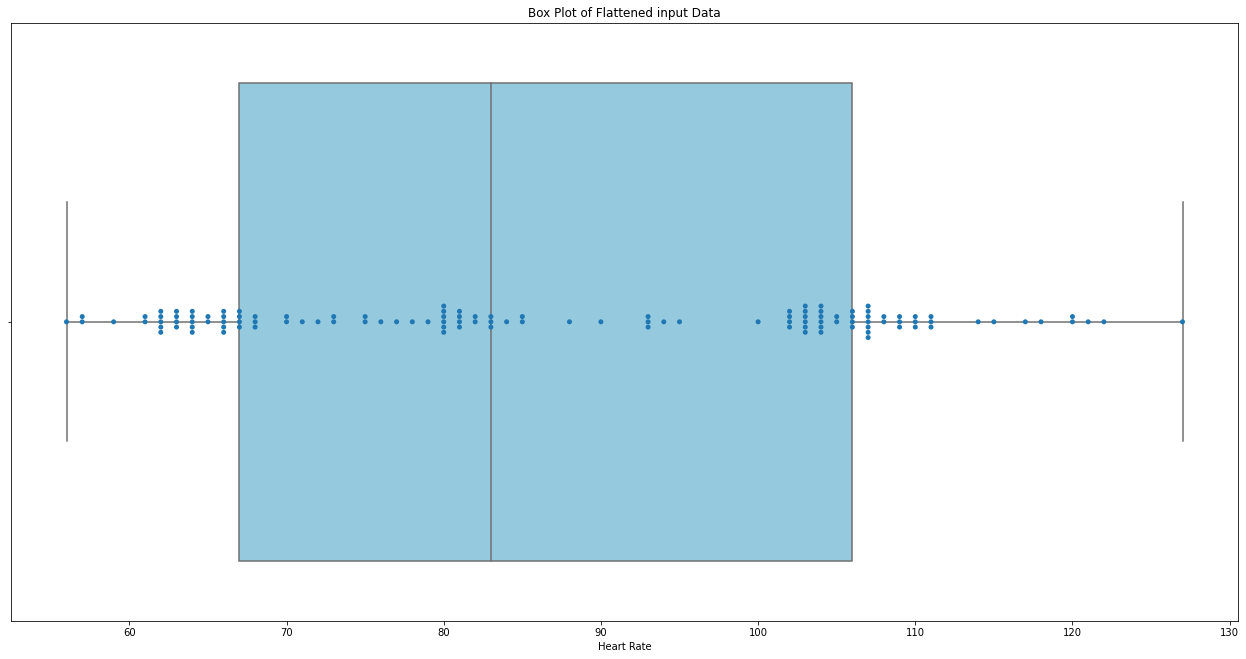

In [183]:
# 데이터 시각화 그래프 사이즈 설정
plt.figure(figsize=(22, 11),facecolor='white')

# 박스 플롯
sns.boxplot(x=hypertension_array_check_max_11_total_11_np.flatten(), color='skyblue')
# Swarm 플롯
sns.swarmplot(hypertension_array_check_max_11_total_11_np.flatten(), label='Original Data')
plt.xlabel('Heart Rate')
plt.title('Box Plot of Flattened input Data')
plt.show()

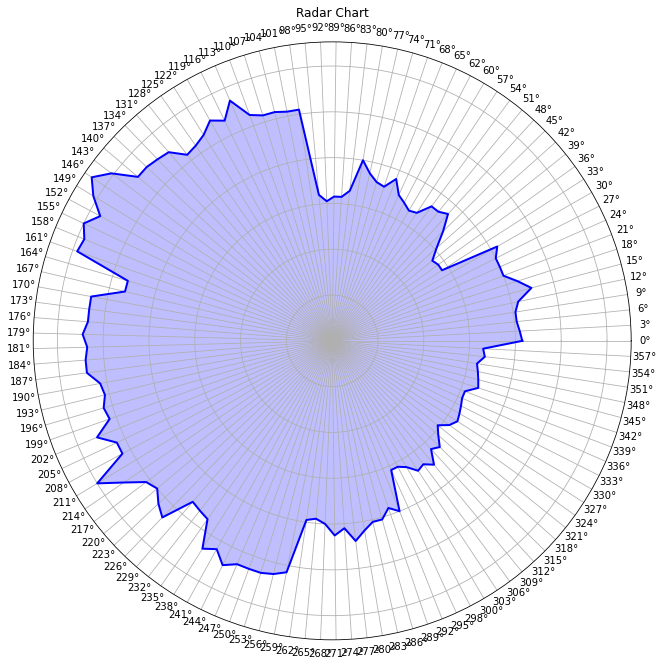

In [184]:
import scipy.stats as stats

# 결과 시각화

# 이차원 리스트를 1차원 리스트로 평탄화
flattened_data = [item for sublist in hypertension_continuity_check_max_11_total for item in sublist]

# 데이터 시각화 그래프 사이즈 설정
plt.figure(figsize=(22, 11),facecolor='white')

# Radar Chart 그리기
# 각도 계산
angles = np.linspace(0, 2 * np.pi, len(flattened_data), endpoint=False).tolist()
# 데이터 원형으로 만들기
values = flattened_data + [flattened_data[0]]
angles += angles[:1]

# Radar Chart 설정
ax = plt.subplot(111, polar=True)
ax.fill(angles, values, 'b', alpha=0.25)
ax.plot(angles, values, 'b', linewidth=2)

# 레이블 추가
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
# ax.set_xticklabels(['Label1', 'Label2', 'Label3', 'Label4', 'Label5', 'Label6'])  # 각도 레이블
plt.title('Radar Chart')
plt.show()

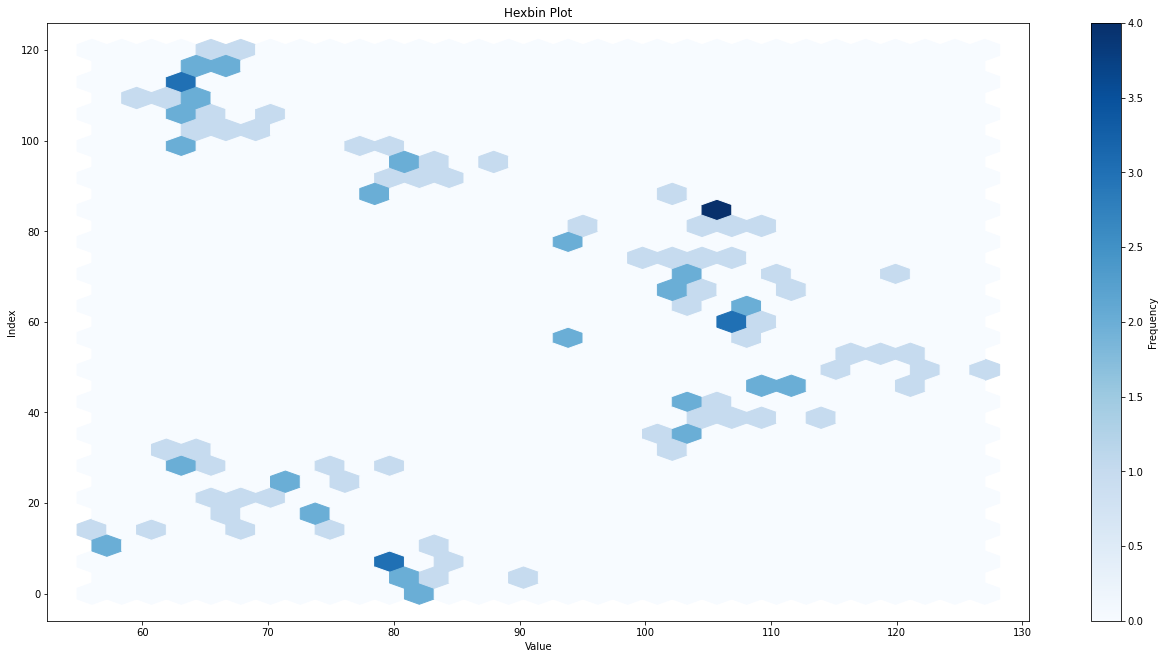

In [185]:
# 데이터 시각화 그래프 사이즈 설정
plt.figure(figsize=(22, 11),facecolor='white')

# Hexbin Plot 그리기
plt.hexbin(flattened_data, range(len(flattened_data)), gridsize=30, cmap='Blues')
plt.colorbar(label='Frequency')
plt.xlabel('Value')
plt.ylabel('Index')
plt.title('Hexbin Plot')
plt.show()

In [186]:
from sklearn.preprocessing import MinMaxScaler

# 스케일러 생성
scaler = MinMaxScaler()

# 데이터를 0과 1 사이로 스케일링
hypertension_mmscaled_data = scaler.fit_transform(hypertension_array_check_max_11_total_11_np)

hypertension_mmscaled_data

array([[0.5       , 0.47169811, 0.45454545, 0.4       , 0.3559322 ,
        0.38333333, 0.36206897, 0.32692308, 0.31034483, 0.36206897,
        0.36363636],
       [0.        , 0.        , 0.        , 0.        , 0.10169492,
        0.13333333, 0.15517241, 0.19230769, 0.0862069 , 0.12068966,
        0.09090909],
       [0.25      , 0.35849057, 0.27272727, 0.22      , 0.22033898,
        0.21666667, 0.03448276, 0.        , 0.01724138, 0.03448276,
        0.01818182],
       [0.86538462, 0.8490566 , 0.85454545, 0.84      , 0.72881356,
        0.78333333, 0.74137931, 0.90384615, 0.75862069, 0.77586207,
        0.72727273],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ],
       [0.69230769, 0.67924528, 0.92727273, 0.92      , 0.76271186,
        0.7       , 0.74137931, 0.86538462, 0.79310345, 0.75862069,
        0.70909091],
       [0.90384615, 0.86792453, 1.        , 0.86      , 0.

In [187]:
# 재구성된 결과 얻기
anomalies = autoencoder.predict(hypertension_mmscaled_data)
anomalies

array([[0.44927576, 0.44034186, 0.43729702, 0.4061224 , 0.3517525 ,
        0.36929214, 0.36078477, 0.34046715, 0.34805143, 0.34351242,
        0.33518583],
       [0.10427374, 0.09503299, 0.11240575, 0.08638909, 0.07503858,
        0.09883189, 0.08636948, 0.07617351, 0.08066741, 0.07148576,
        0.06653297],
       [0.18114585, 0.17999426, 0.18195671, 0.15587538, 0.13243136,
        0.15382719, 0.13279411, 0.12306947, 0.12761635, 0.11569497,
        0.11016929],
       [0.8305851 , 0.82579756, 0.8243276 , 0.7887713 , 0.72048414,
        0.7582674 , 0.7771103 , 0.7290448 , 0.7322161 , 0.7398858 ,
        0.73740447],
       [0.92513704, 0.9302163 , 0.9236059 , 0.9011816 , 0.86572266,
        0.88522154, 0.8955642 , 0.86694014, 0.869114  , 0.8723298 ,
        0.8715683 ],
       [0.81500983, 0.81680584, 0.81387293, 0.77470064, 0.71309316,
        0.7463474 , 0.7638768 , 0.71878564, 0.72357893, 0.7320804 ,
        0.72757375],
       [0.85127157, 0.8574178 , 0.84893703, 0.8132433 , 0.

In [188]:
# 모델 평가
anomalies_loss = autoencoder.evaluate(hypertension_mmscaled_data, hypertension_mmscaled_data)
print(f'평균 제곱 오차: {anomalies_loss}')

1/1 [==============================] - 0s 10ms/step - loss: 0.0056
평균 제곱 오차: 0.005552700720727444


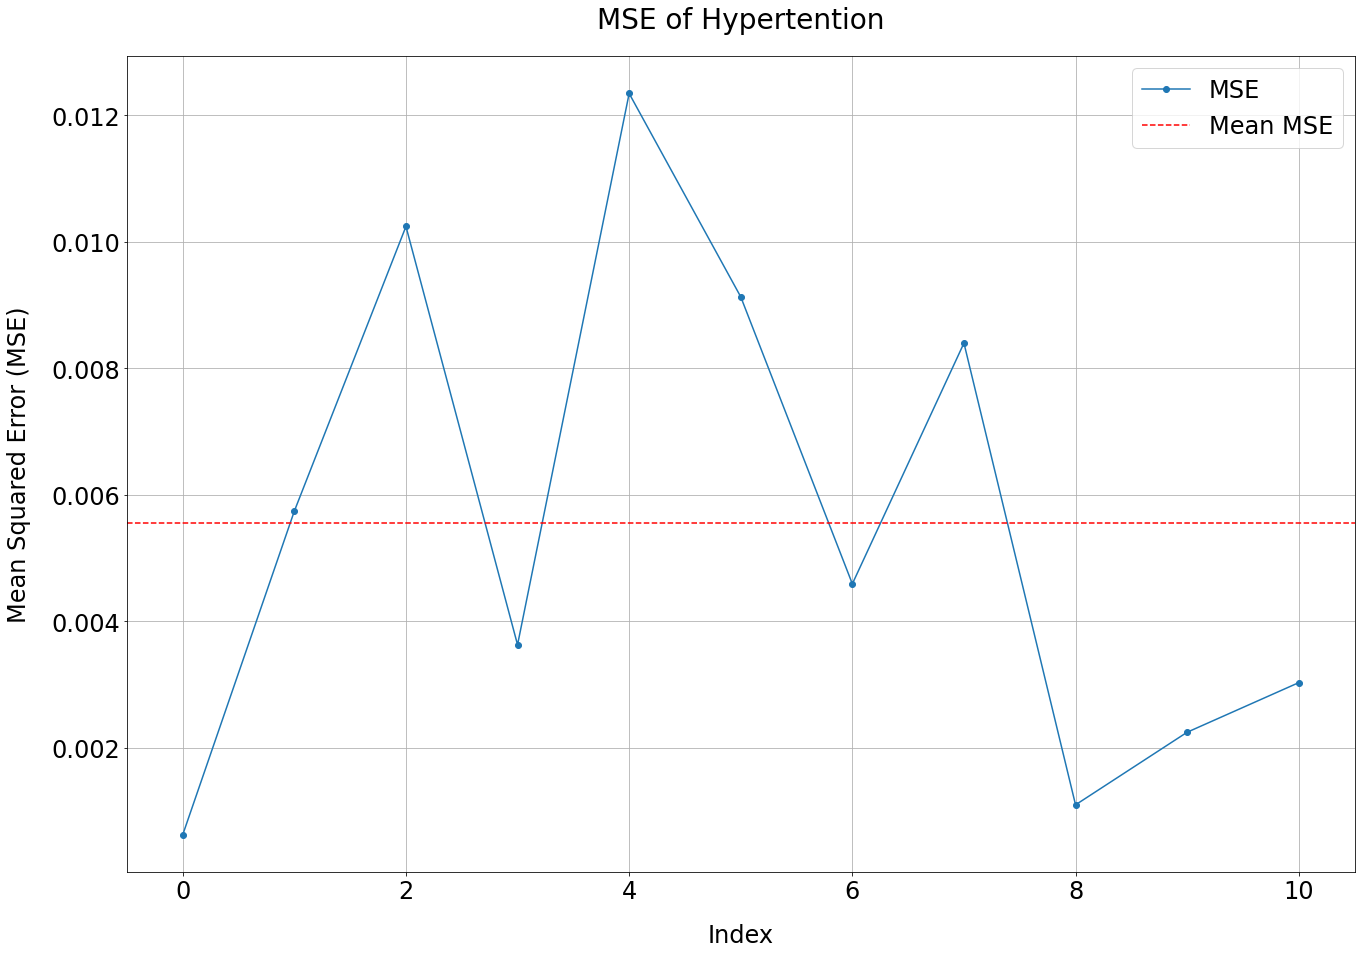

hypertension Mean MSE = 0.005552700729709156
hypertension_mse_values = [0.0006242216291500675, 0.005742746697915132, 0.010243691497693564, 0.0036285029223822878, 0.01234701425465898, 0.00913066317187834, 0.004591763459910805, 0.008399222483517422, 0.0010971687247088144, 0.002245266380510921, 0.0030294468044743767]


In [189]:
from sklearn.metrics import mean_squared_error
# test_data와 decoded_data의 MSE 값을 계산하여 저장
hypertension_mse_values = [mean_squared_error(test_seq, decoded_seq) for test_seq, decoded_seq in zip(hypertension_mmscaled_data, anomalies)]

# 각 데이터에 대한 MSE 값을 그래프로 시각화
plt.figure(figsize=(22, 15),facecolor='white')
plt.plot(np.arange(len(hypertension_mse_values)), hypertension_mse_values, marker='o', linestyle='-', label='MSE')
# plt.axhline(np.mean(mse_values), color='red', linestyle='--', label='Mean MSE')
plt.axhline(np.mean(hypertension_mse_values), color='red', linestyle='--', label='Mean MSE')
# plt.axhline(np.mean(threshold), color='red', linestyle='--', label='Threshold')

plt.xlabel('Index', fontsize=24, labelpad=20)
plt.ylabel('Mean Squared Error (MSE)', fontsize=24, labelpad=20)
plt.title('MSE of Hypertention', fontsize=28, pad=28)
plt.legend(fontsize=24)
plt.grid(True)

plt.xticks(fontsize=24)  # X 라벨 폰트 크기 설정
plt.yticks(fontsize=24)  # Y 라벨 폰트 크기 설정

plt.show()

# print('mse_mean =', np.mean(mse_values))
print('hypertension Mean MSE =', np.mean(hypertension_mse_values))
print('hypertension_mse_values =', hypertension_mse_values)

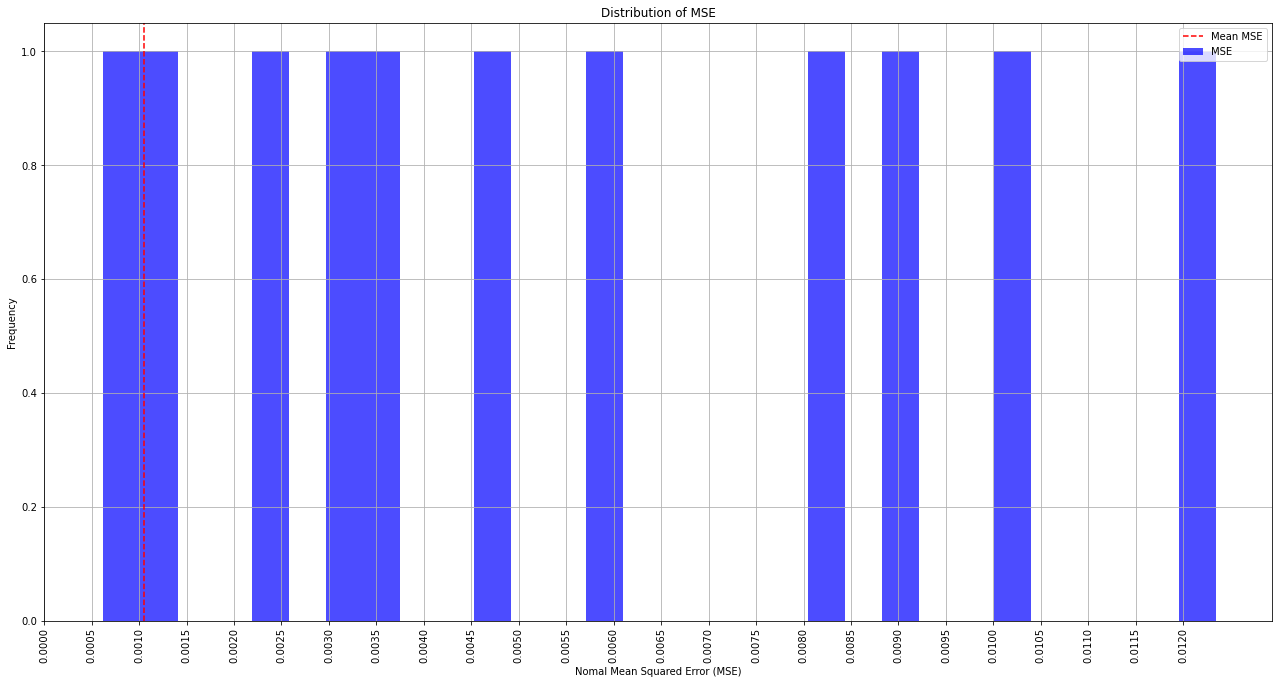

In [190]:
# MSE 값의 분포를 히스토그램으로 표시
plt.figure(figsize=(22, 11),facecolor='white')
plt.hist(hypertension_mse_values, bins=30, color='blue', alpha=0.7, label='MSE')
plt.axvline(np.mean(mse_values), color='red', linestyle='--', label='Mean MSE')
plt.xlabel('Nomal Mean Squared Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of MSE')
plt.legend()
plt.grid(True)

# x 축 눈금 설정
plt.xticks(np.arange(0, max(mse_values), 0.0005), rotation=90)

plt.show()

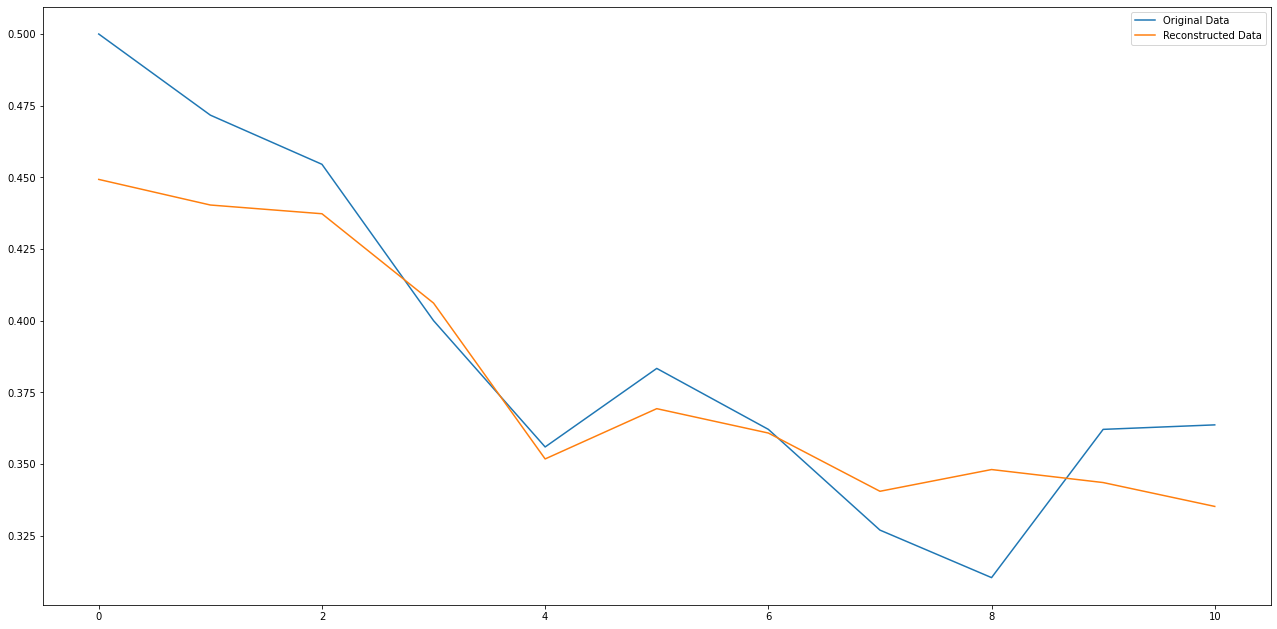

In [191]:

# 재구성 결과 시각화
plt.figure(figsize=(22, 11),facecolor='white')
plt.plot(hypertension_mmscaled_data[0], label='Original Data')
plt.plot(anomalies[0], label='Reconstructed Data')
plt.legend()
plt.show()

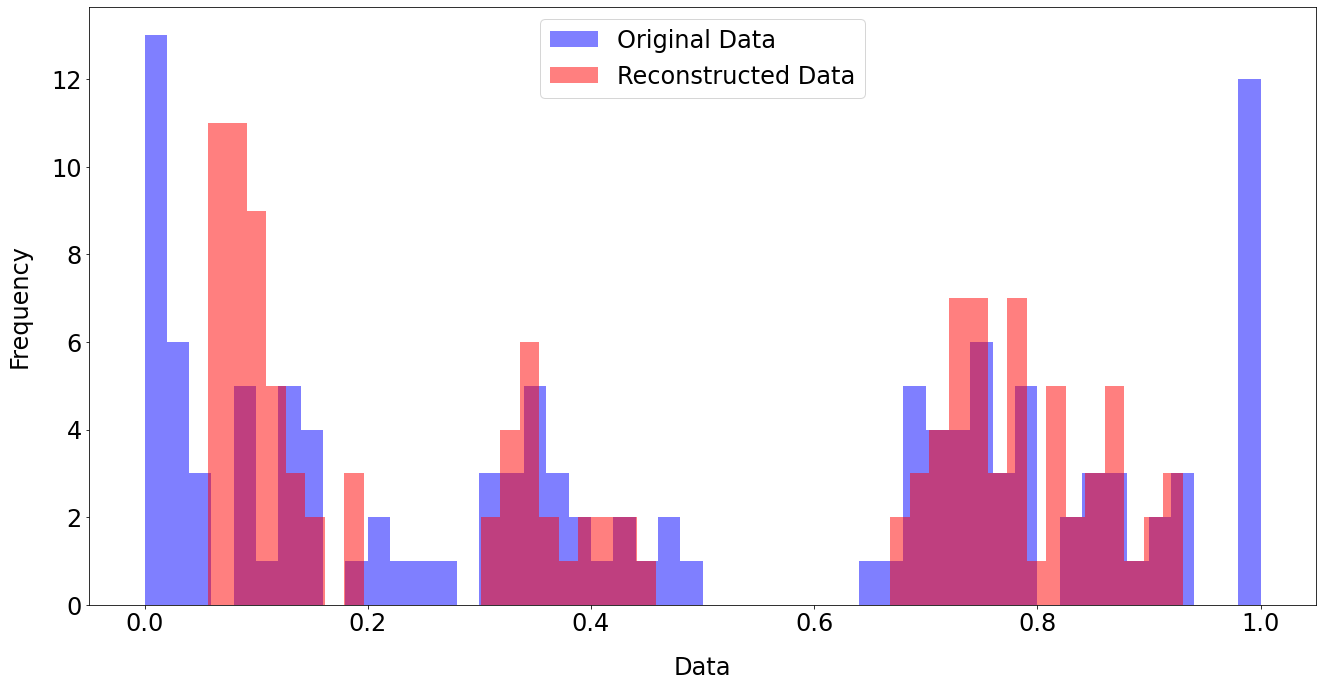

In [192]:
# 히스토그램 분석: 재구성된 데이터와 원본 데이터의 분포를 비교하여 모델의 성능을 확인

plt.figure(figsize=(22, 11),facecolor='white')
plt.hist(hypertension_mmscaled_data.flatten(), bins=50, alpha=0.5, color='blue', label='Original Data')
plt.hist(anomalies.flatten(), bins=50, alpha=0.5, color='red', label='Reconstructed Data')

plt.xlabel('Data', fontsize=24, labelpad=20)
plt.ylabel('Frequency', fontsize=24, labelpad=20)

plt.xticks(fontsize=24)  # X 라벨 폰트 크기 설정
plt.yticks(fontsize=24)  # Y 라벨 폰트 크기 설정
plt.legend(fontsize=24)

plt.show()

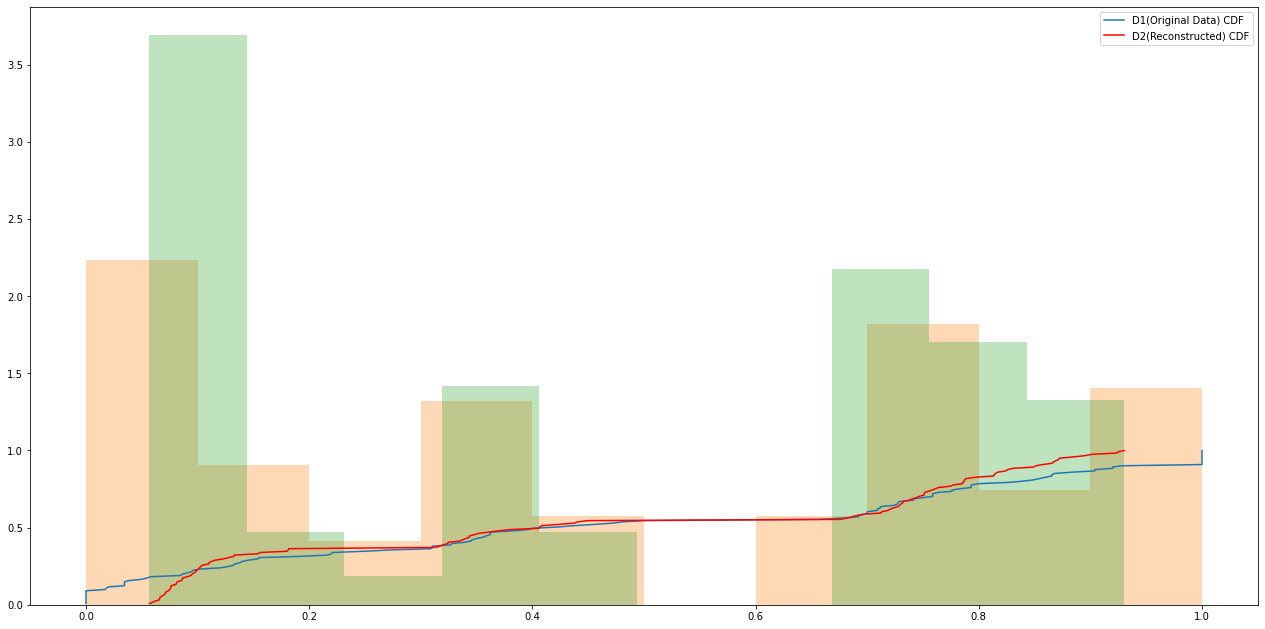

In [193]:
# 인풋데이터와 디코딩된 데이터 비교 확인 히스토그램 그래프에 CDF(누적 분포 함수) 추가
# 빈(Bin) 크기를 변경할 때 구조가 변경될 수 있고 각 빈에는 통계적 불확실성이 존재 할 수 있어 CDF 확인
# Empirical 경험적 Cumulative 누적 Distribution 분포 Functions 함수

d1 = hypertension_mmscaled_data.flatten()
d2 = anomalies.flatten()
sd1 = np.sort(d1)
sd2 = np.sort(d2)
cdf = np.linspace(1/d1.size, 1, d1.size)

plt.figure(figsize=(22, 11), facecolor='white')
plt.plot(sd1, cdf, label="D1(Original Data) CDF")
plt.plot(sd2, cdf, color = "red", label="D2(Reconstructed) CDF")
plt.hist(d1,  density=True, alpha=0.3)
plt.hist(d2,  density=True, alpha=0.3)
plt.legend()
plt.show()

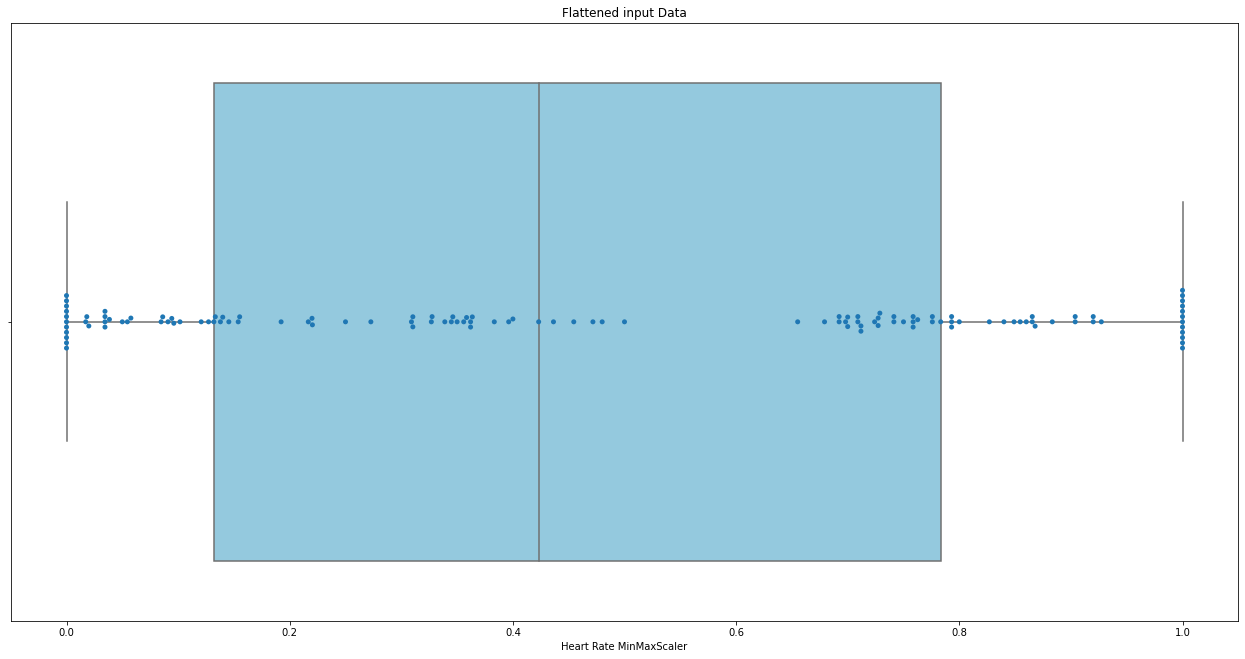

In [194]:
# 인풋데이터 전체 형상을 보기 위한 Box + Swarm Plots

# 데이터 시각화 그래프 사이즈 설정
plt.figure(figsize=(22, 11),facecolor='white')

# Box 플롯
sns.boxplot(x=hypertension_mmscaled_data.flatten(), color='skyblue')
# Swarm 플롯
sns.swarmplot(hypertension_mmscaled_data.flatten(), label='Original Data')
plt.xlabel('Heart Rate MinMaxScaler')
plt.title('Flattened input Data')
plt.show()

In [195]:
hypertension_mmscaled_data

array([[0.5       , 0.47169811, 0.45454545, 0.4       , 0.3559322 ,
        0.38333333, 0.36206897, 0.32692308, 0.31034483, 0.36206897,
        0.36363636],
       [0.        , 0.        , 0.        , 0.        , 0.10169492,
        0.13333333, 0.15517241, 0.19230769, 0.0862069 , 0.12068966,
        0.09090909],
       [0.25      , 0.35849057, 0.27272727, 0.22      , 0.22033898,
        0.21666667, 0.03448276, 0.        , 0.01724138, 0.03448276,
        0.01818182],
       [0.86538462, 0.8490566 , 0.85454545, 0.84      , 0.72881356,
        0.78333333, 0.74137931, 0.90384615, 0.75862069, 0.77586207,
        0.72727273],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ],
       [0.69230769, 0.67924528, 0.92727273, 0.92      , 0.76271186,
        0.7       , 0.74137931, 0.86538462, 0.79310345, 0.75862069,
        0.70909091],
       [0.90384615, 0.86792453, 1.        , 0.86      , 0.

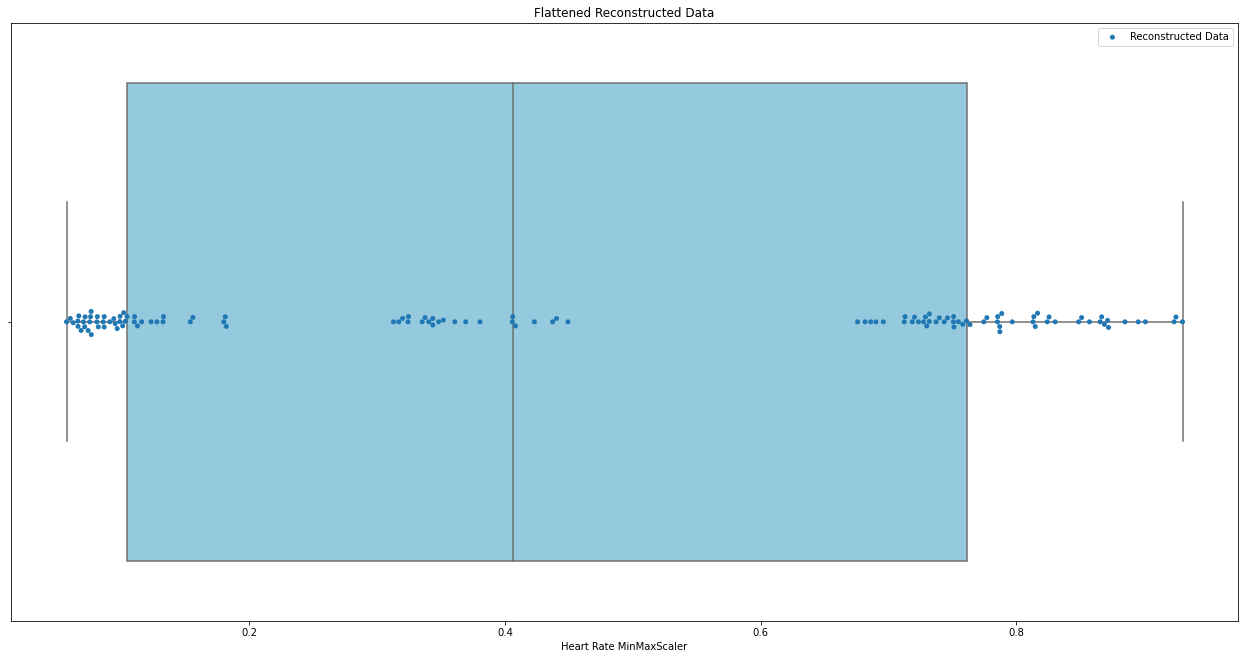

In [196]:
# 디코딩된 데이터 전체 형상을 보기 위한 Box + Swarm Plots

plt.figure(figsize=(22, 11),facecolor='white')
# Box 플롯
sns.boxplot(x=anomalies.flatten(), color='skyblue')
# Swarm 플롯
sns.swarmplot(anomalies.flatten(), label='Reconstructed Data')
plt.xlabel('Heart Rate MinMaxScaler')
plt.title('Flattened Reconstructed Data')
plt.legend()
plt.show()

In [197]:
anomalies

array([[0.44927576, 0.44034186, 0.43729702, 0.4061224 , 0.3517525 ,
        0.36929214, 0.36078477, 0.34046715, 0.34805143, 0.34351242,
        0.33518583],
       [0.10427374, 0.09503299, 0.11240575, 0.08638909, 0.07503858,
        0.09883189, 0.08636948, 0.07617351, 0.08066741, 0.07148576,
        0.06653297],
       [0.18114585, 0.17999426, 0.18195671, 0.15587538, 0.13243136,
        0.15382719, 0.13279411, 0.12306947, 0.12761635, 0.11569497,
        0.11016929],
       [0.8305851 , 0.82579756, 0.8243276 , 0.7887713 , 0.72048414,
        0.7582674 , 0.7771103 , 0.7290448 , 0.7322161 , 0.7398858 ,
        0.73740447],
       [0.92513704, 0.9302163 , 0.9236059 , 0.9011816 , 0.86572266,
        0.88522154, 0.8955642 , 0.86694014, 0.869114  , 0.8723298 ,
        0.8715683 ],
       [0.81500983, 0.81680584, 0.81387293, 0.77470064, 0.71309316,
        0.7463474 , 0.7638768 , 0.71878564, 0.72357893, 0.7320804 ,
        0.72757375],
       [0.85127157, 0.8574178 , 0.84893703, 0.8132433 , 0.

In [198]:
# 워치 수집 데이터 기간 확인

print('최대 measure_time:', df['measure_time'].max())
print('최소 measure_time:', df['measure_time'].min())


최대 measure_time: 2023-07-23 15:37:00
최소 measure_time: 2022-07-12 14:20:00


In [254]:
# 정상 282, 고혈압 11
# 임계치 변경 결과 확인 테스트
threshold = 0.0045
print('threshold',threshold)

TP = np.sum(np.array(mse_values) <= threshold)
print('정상을 정상으로 TP',TP)
FN = np.sum(np.array(mse_values) > threshold)
print('정상을 비정상으로 FN',FN)
FP = np.sum(np.array(hypertension_mse_values) <= threshold)
print('고혈압을 정상으로 FP',FP)
TN = np.sum(np.array(hypertension_mse_values) > threshold)
print('고혈압을 비정상으로 TN',TN)

# 정확도 계산
accuracy = (TP + TN) / (TP + FN + FP + TN)

# 정밀도 계산
precision = TP / (TP + FP)

# 재현율 계산
recall = TP / (TP + FN)

# F1 스코어 계산
f1_score = 2 * (precision * recall) / (precision + recall)

# 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

threshold 0.0045
정상을 정상으로 TP 275
정상을 비정상으로 FN 7
고혈압을 정상으로 FP 5
고혈압을 비정상으로 TN 6
Accuracy: 0.9590
Precision: 0.9821
Recall: 0.9752
F1 Score: 0.9786


In [ ]:
import random
# Assuming mse_values is your list
mse_values_random11 = random.sample(mse_values, 11)

In [251]:
# 정상 11 (282중 랜던 추출), 고혈압 11
# 임계치 변경 결과 확인 테스트
threshold = 0.0045
print('threshold',threshold)

TP = np.sum(np.array(mse_values_random11) <= threshold)
print('정상을 정상으로 TP',TP)
FN = np.sum(np.array(mse_values_random11) > threshold)
print('정상을 비정상으로 FN',FN)
FP = np.sum(np.array(hypertension_mse_values) <= threshold)
print('고혈압을 정상으로 FP',FP)
TN = np.sum(np.array(hypertension_mse_values) > threshold)
print('고혈압을 비정상으로 TN',TN)

# 정확도 계산
accuracy = (TP + TN) / (TP + FN + FP + TN)

# 정밀도 계산
precision = TP / (TP + FP)

# 재현율 계산
recall = TP / (TP + FN)

# F1 스코어 계산
f1_score = 2 * (precision * recall) / (precision + recall)

# 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

threshold 0.0045
정상을 정상으로 TP 11
정상을 비정상으로 FN 0
고혈압을 정상으로 FP 5
고혈압을 비정상으로 TN 6
Accuracy: 0.7727
Precision: 0.6875
Recall: 1.0000
F1 Score: 0.8148


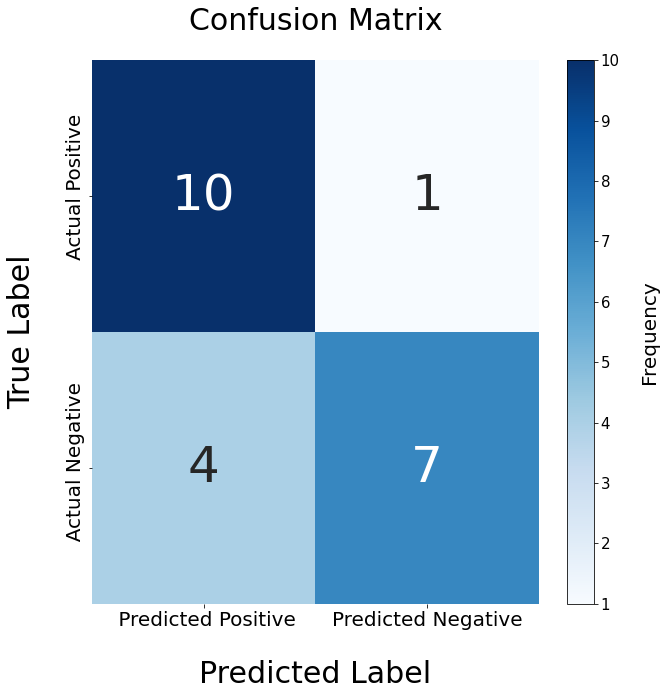

In [201]:
# 혼동 행렬 생성
conf_matrix = [[TP, FN], [FP, TN]]

# 혼동 행렬을 seaborn의 heatmap으로 그리기
plt.figure(figsize=(10, 10), facecolor='white')
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 50}, cbar=False)
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 50}, cbar=False)

# 글꼴 크기 설정
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
plt.yticks([0.5, 1.5], ['   Actual Positive', '  Actual Negative'], fontsize=20, va='center')
plt.xticks([0.5, 1.5], [' Predicted Positive', 'Predicted Negative'], fontsize=20, ha='center')
plt.xlabel('Predicted Label', fontsize=30, labelpad=30)
plt.ylabel('True Label', fontsize=30, labelpad=30)
plt.title('Confusion Matrix', fontsize=30, pad=30)

# colorbar 설정
cbar = plt.gcf().colorbar(heatmap.collections[0], ax=plt.gca(), pad=0.05)
cbar.set_label('Frequency', fontsize=20, labelpad=20)  # colorbar 라벨과 패딩 추가
cbar.ax.tick_params(labelsize=15)  # colorbar 눈금 사이즈 설정

plt.show()


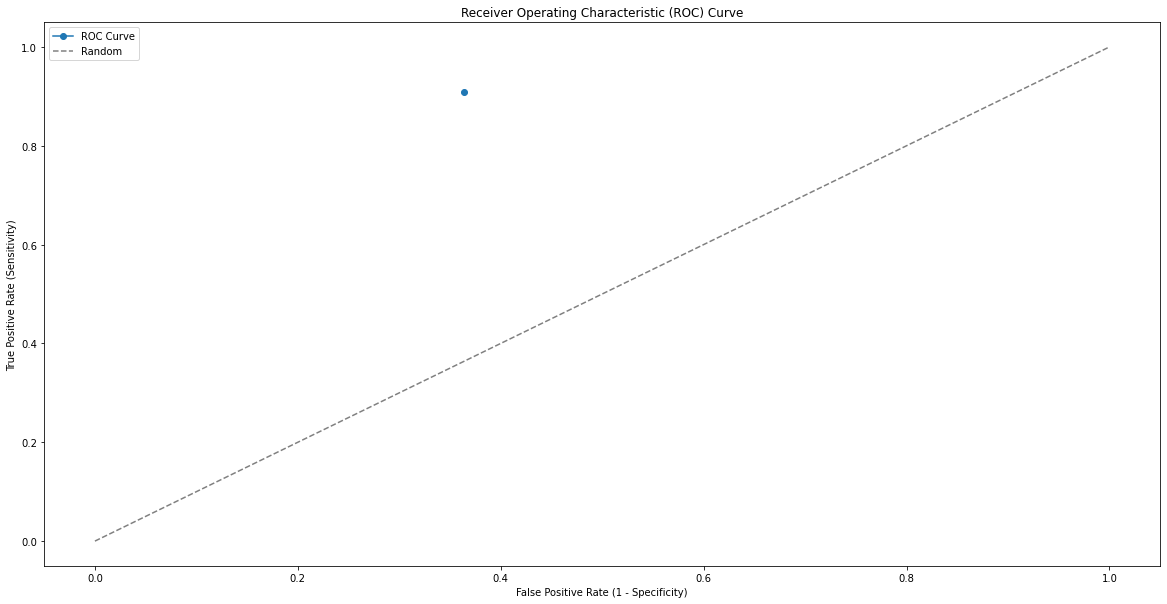

In [202]:
import matplotlib.pyplot as plt

# Compute True Positive Rate (Sensitivity) and False Positive Rate
tpr = TP / (TP + FN)
fpr = FP / (FP + TN)

# Plot ROC curve
plt.figure(figsize=(20, 10), facecolor='white')
plt.plot(fpr, tpr, marker='o', label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.show()


In [203]:
# Create binary lists based on the threshold
y_true = [0] * len(hypertension_mse_values) + [1] * len(mse_values)
y_probs = [False if mse <= threshold else True for mse in hypertension_mse_values] + [True if mse > threshold else False for mse in mse_values]

In [204]:
y_true

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [205]:
y_probs

[False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 Fa

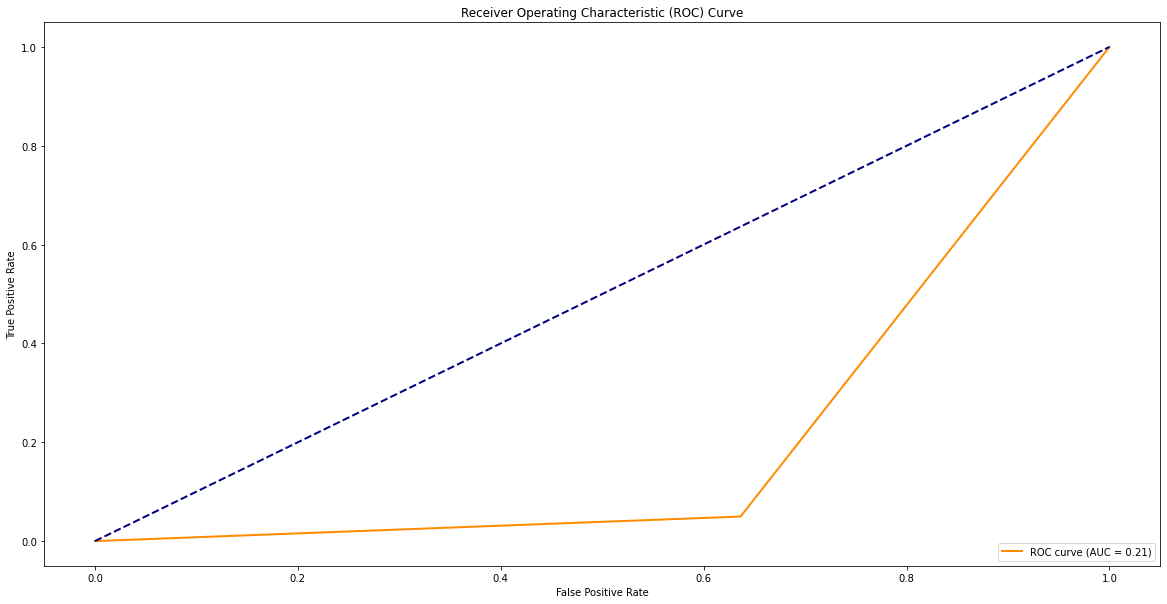

In [206]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(20, 10), facecolor='white')
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()